## Packages

In [ ]:
pip install --quiet optuna

In [485]:
# Basics
import numpy as np
import pandas as pd
from scipy import stats
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

import os
import time

# Regression
import statsmodels.api as sm
from scipy.interpolate import griddata

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

# ML Tools
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

# RF
from sklearn.ensemble import RandomForestRegressor

# XGB
import xgboost as xgb
from xgboost import XGBRegressor

# NN
import math
import torch
import torch.nn as nn
import tensorflow
import optuna
import optuna.visualization as opt_vis
import copy

## Config

In [340]:
# working_dir = "~/Documents/GitHub/COMP3010/Assignment/Data/"

# train_dir = os.path.join(working_dir, "train.csv")
# test_dir = os.path.join(working_dir, "test.csv")

train_dir = "https://raw.githubusercontent.com/harvey-py/COMP3010/main/Assignment/Data/train.csv"
test_dir = "https://raw.githubusercontent.com/harvey-py/COMP3010/main/Assignment/Data/test.csv"

## Importing Data

In [517]:
raw_data = pd.read_csv(train_dir)
raw_data.rename(columns = {"Target Pressure (bar)": "tgt_pressure"}, inplace = True)

In [518]:
raw_test_data = pd.read_csv(test_dir)
raw_test_data.rename(columns = {"Target Pressure (bar)": "tgt_pressure"}, inplace = True)

# Exploratory Analysis

Goal: to gain an understanding of the data and identify any noteworthy relationships

In [5]:
raw_data.columns

Index(['ID', 'Tank Failure Pressure (bar)', 'Liquid Ratio (%)',
       'Tank Width (m)', 'Tank Length (m)', 'Tank Height (m)',
       'BLEVE Height (m)', 'Vapour Height (m)', 'Vapour Temperature (K)',
       'Liquid Temperature (K)', 'Obstacle Distance to BLEVE (m)',
       'Obstacle Width (m)', 'Obstacle Height (m)', 'Obstacle Thickness (m)',
       'Obstacle Angle', 'Status', 'Liquid Critical Pressure (bar)',
       'Liquid Boiling Temperature (K)', 'Liquid Critical Temperature (K)',
       'Sensor ID', 'Sensor Position Side', 'Sensor Position x',
       'Sensor Position y', 'Sensor Position z', 'tgt_pressure'],
      dtype='object')

In [6]:
raw_data

ID  Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
0       3203.0                         7.32              0.42            2.42   
1       3204.0                         7.18              0.42            2.39   
2       3205.0                         7.32              0.41            2.39   
3       3206.0                         7.26              0.42            2.40   
4       3207.0                         7.32              0.42            2.40   
...        ...                          ...               ...             ...   
10045  10244.0                        36.91              0.64            1.58   
10046  12758.0                        16.44              0.55            0.80   
10047   9438.0                        36.26              0.57            2.38   
10048   8689.0                        14.27              0.50            2.21   
10049  10302.0                        35.52              0.63            1.60   

       Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
0                 5.39             1.00              1.79               0.60   
1                 5.39             1.01              1.81               0.59   
2                 5.38             1.00              1.78               0.62   
3                 5.41             1.00              1.81               0.61   
4                 5.41             1.02              1.79               0.62   
...                ...              ...               ...                ...   
10045             9.39             0.58              1.01               0.22   
10046             5.58             1.99              1.60               0.82   
10047             2.62             2.80              0.60               1.19   
10048             8.40             2.58              1.62               1.40   
10049             7.21             1.60              1.00               0.59   

       Vapour Temperature (K)  Liquid Temperature (K)  ...       Status  \
0                      524.61                  354.49  ...  Superheated   
1                      522.80                  354.31  ...  Superheated   
2                      523.00                  354.59  ...  Superheated   
3                      522.35                  354.37  ...  Superheated   
4                      522.98                  354.33  ...  Superheated   
...                       ...                     ...  ...          ...   
10045                  442.31                  299.28  ...    Subcooled   
10046                  293.54                  285.02  ...    Subcooled   
10047                  349.75                  418.53  ...    Subcooled   
10048                  288.61                  396.96  ...  Superheated   
10049                  436.28                  309.79  ...    Subcooled   

       Liquid Critical Pressure (bar)  Liquid Boiling Temperature (K)  \
0                                37.9                            -1.0   
1                                37.9                            -1.0   
2                                37.9                            -1.0   
3                                37.9                            -1.0   
4                                37.9                            -1.0   
...                               ...                             ...   
10045                            37.9                             NaN   
10046                            37.9                            -1.0   
10047                            37.9                            -1.0   
10048                            37.9                            -1.0   
10049                            42.5                           -42.0   

       Liquid Critical Temperature (K)  Sensor ID Sensor Position Side  \
0                                152.0       18.0                  2.0   
1                                152.0       19.0                  3.0   
2                                152.0       20.0                  3.0   
3   

## Plots

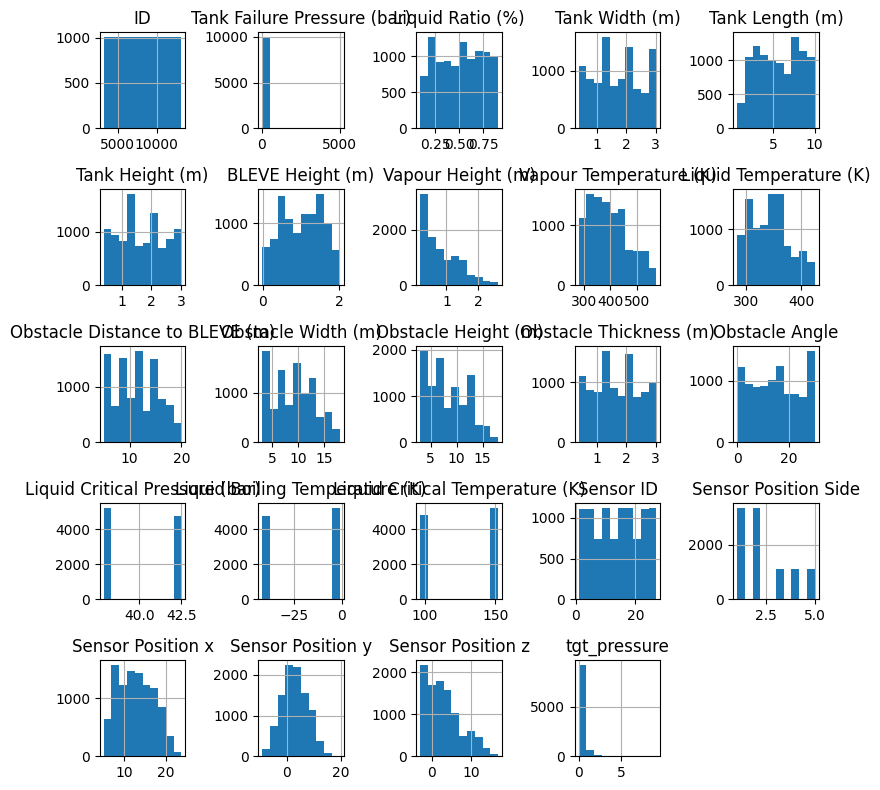

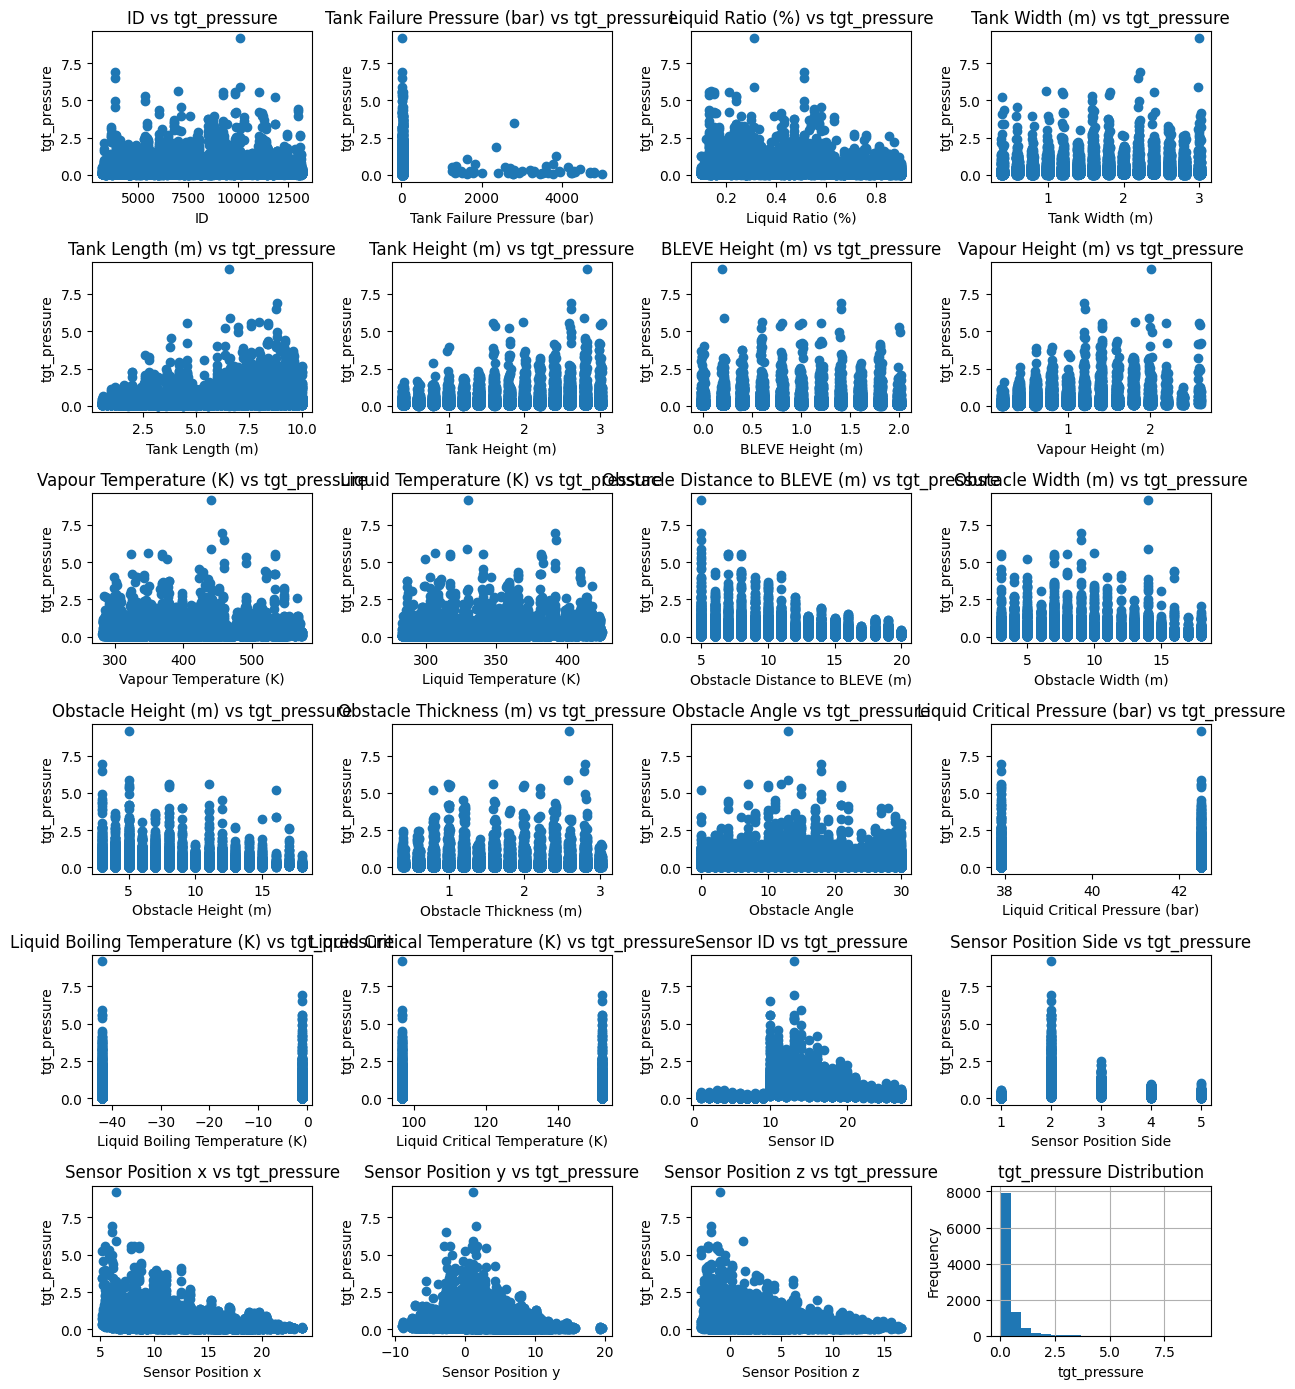

In [7]:
raw_data.hist(figsize = (8,8))
plt.tight_layout()
plt.show()


raw_data_num = raw_data.select_dtypes(include=[np.number])

n_cols = 4
n_rows = 6 # int(len(raw_data_num.columns) / n_cols) + (len(raw_data_num.columns) % n_cols > 0)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 14))
axs = axs.flatten()

i = 0
for col_name in raw_data_num.columns:
    if col_name != "tgt_pressure":
        ax = axs[i]
        i += 1
        ax.scatter(raw_data_num[col_name], raw_data_num["tgt_pressure"])
        ax.set_title(f"{col_name} vs tgt_pressure")
        ax.set_xlabel(col_name)
        ax.set_ylabel("tgt_pressure")

raw_data_num["tgt_pressure"].hist(ax = axs[i], bins = 20)
axs[i].set_title("tgt_pressure Distribution")
axs[i].set_xlabel("tgt_pressure")
axs[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Observations (mostly talking about the scatter plots):
* Tank Failure Pressure
    * Has a weird distribution, with many points near 0 (although the line is not completely straight, suggesting that not all points are 0), whilst there are some points in the 1000s
        * Whilst this could simply be due to the underlying process, this could be also due to measurement errors (this will be discussed further later)
* Tank Dimensions
    * tgt_pressure appear to be proportional to the tank's length and height
        * This makes sense, as the more fuel a tank carries, the more "fuel" for the explosion
    * The lack of a noticeable relationship in width is odd, although it may be due to noise
        * There doesn't appear to be any underlying reason for this - as it is hard to believe that a wider tank given the exact same conditions would lead to the same blast pressure, as there would be more liquid to vaporise - but we will investigate this further below
    * Feature to add:
        * tank_volume
* Vapour Height & Liquid Ratio
    * vapour_height seems to be a relatively important predictor - there is a fairly nice trend between vapour_height and tgt_pressure, as well as the opposite trend for liquid_ratio
        * This makes sense, given that BLEVEs occur due to the sudden vaporisation of liquids, so more liquid leads to more potential vapor being suddenly produced leading to a stronger BLEVE
    * Feature to add:
        * liquid_volume
* Vapour and Liquid Temp
    * The frequency histograms show that frequency vapour and liquid temp roughly half after a certain point
        * This may be confusing initially, but makes more sense once we realise that there are only 2 unique substances in play (see the next main point)
    * Both seem to have orgins around 0ºC (273K), however the vapour_temp goes much higher
        * This makes sense as beyond a certain point, liquids will turn into gasses (or supercritical fluids) regardless of their temperature
            * This also appears to coincide with the critical temperature observed (see below point)
* Critical Pressure, Boiling Temp and Critical Temp
    * There are 2 distinct values for each of the listed variables
        * This makes sense, as whilst a substance's material can range from trial to trial, their underlying properties (e.g. boiling point given constant conditions) should not change.
        * This interestingly suggests the presence of a few unique substances (likely only 2), which can potentially be identified to help gain other properties from the data
    * Furthermore, the listed "boiling temperatures" raise red flags, as the contain values in the range of negative Kelvin
        * This should be impossible, as no substance should boil at a temperature below absolute 0 (as the temperature required to be a solid, liquid and even some forms of gas is below the coldest temperature. Whilst one can argue the existence of such a substance in a hypothetical scenario (where it only exists in a gaseous form), it appears extremely unlikely and unreasonable, especially given that we are investigating BLEVEs where the explosion's orginiates from vaporising liquid
        * As a result, we can conclude this is likely a measurement error and that the recorded values for both boiling and critical temp are supposed to be in ºC rather than K. We can also validate this through research - we can find that 1) there are only 2 unique substances in the data and 2) that their properties match up exactly with n-butane and propane (which will be shown later).
    * Feature to add:
        * Substance type
* Sensor
    * Sensors 1-9 produce very low target_pressure values, whilst 10-18 have the highest and 19-27 are in-between
        * This (again) makes sense, as sensors 1-9 are on the back of the obstacle ("shielded" from the blast) and 10-18 are on the side facing the blast
        * We must ensure that our model is able to distinguish between these separate cases
* Sensor Position
    * It appears that tgt_pressure is inversely proportional to (the magnitude of) sensor positions
        * This does not come as a surprise, as the 2 biggest factors in this analysis should be 1) the pressure generated from the explosion, 2) the distance of the sensor from said explosion (as well as the placement of the sensor on the wall)
    * Feature to add:
        * net_sensor_distance

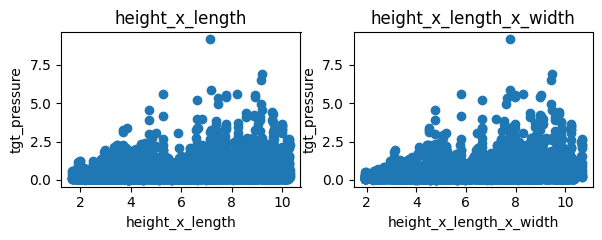

In [8]:
# Investigating the effect of width
raw_data_num["height_x_length"] = np.linalg.norm(raw_data_num[["Tank Height (m)", "Tank Length (m)"]], axis = 1)
raw_data_num["height_x_length_x_width"] = np.linalg.norm(raw_data_num[["height_x_length", "Tank Width (m)"]], axis = 1)

fig, axs = plt.subplots(1, 2, figsize=(6, 2.5))

for i, col_name in enumerate(["height_x_length", "height_x_length_x_width"]):
    ax = axs[i]
    ax.scatter(raw_data_num[col_name], raw_data_num["tgt_pressure"])
    ax.set_title(f"{col_name}")
    ax.set_xlabel(col_name)
    ax.set_ylabel("tgt_pressure")

plt.tight_layout()
plt.show()

Whilst being arguably "less smooth", there does not appear to be a significant difference in tgt_pressure's relationship between height_x_length and height_x_length_x_width. As a result, we will use height_x_lenght_x_width as a factor (tank's volume), as there is no underlying reason to believe that height_x_length would make for a better predictor.

In [9]:
# Add corr_plots post-feature engineering

In [10]:
raw_data_num.corr().style.background_gradient(cmap = "coolwarm", vmin = -1, vmax = 1)

In [11]:
raw_data_num.corr()[["tgt_pressure"]].T.style.background_gradient(cmap = "coolwarm", vmin = -1, vmax = 1)

# Data Preprocessing

## Missing Values

In [539]:
raw_nans = raw_data[raw_data.isna().any(axis = 1)]
print(f"{len(raw_nans)} points with NaNs out of {len(raw_data)} ({len(raw_nans)/len(raw_data)*100:.3f}%)\n")

for i in [1,2,20,21]:
    print(f"Rows with {i} or more NaNs: {len(raw_data[raw_data.isna().sum(axis = 1) >= i])}")

112 points with NaNs out of 10050 (1.114%)

Rows with 1 or more NaNs: 112
Rows with 2 or more NaNs: 10
Rows with 20 or more NaNs: 10
Rows with 21 or more NaNs: 0


In [547]:
def replace_single_nan(row):
    nan_count = row.isnull().sum()
    if nan_count == 1:
        col_with_nan = row[row.isnull()].index[0]
        row[col_with_nan] = raw_data[col_with_nan].median()
    return row

# 1: Removing NaNs
raw_data1 = raw_data.apply(replace_single_nan, axis=1)
raw_data1.dropna(inplace = True)

## Outliers

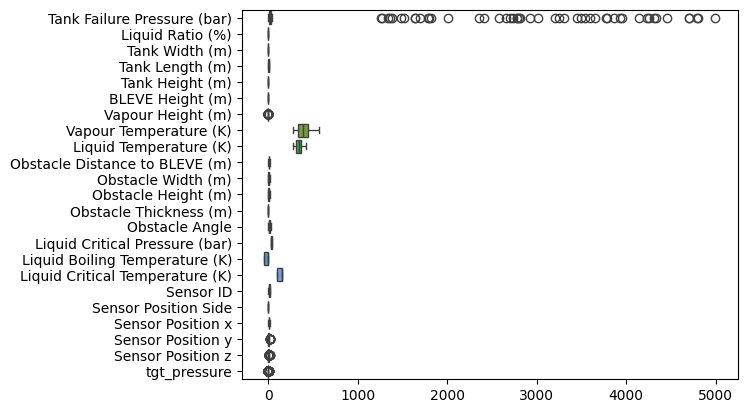

In [945]:
# 2: Handling Outliers
outlier_df = raw_data1.drop("ID", axis = 1).select_dtypes(exclude=['object']).copy()
sns.boxplot(outlier_df, orient = "h")
plt.show()

It is apparent that "Tank Failure Pressure" has a large amount of outliers. We'll investigate thisbelow

In [16]:
outlier_count = len(raw_data1.query("`Tank Failure Pressure (bar)` > 1000"))
outlier_df.sort_values("Tank Failure Pressure (bar)", ascending = False, inplace = True)
display(outlier_df.iloc[outlier_count - 3 : outlier_count + 3])

Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
1738                  1342.242706              0.20            1.21   
2484                  1270.544969              0.85            2.41   
4647                  1257.523808              0.73            1.61   
5690                    42.180000              0.43            1.80   
5696                    42.160000              0.43            1.80   
5700                    42.120000              0.43            1.82   

      Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
1738             6.22             1.01              0.21               0.78   
2484             5.58             2.38              0.18               0.40   
4647             7.98             2.41              0.81               0.62   
5690             9.80             1.40              0.41               0.82   
5696             9.78             1.42              0.39               0.82   
5700             9.79             1.38              0.39               0.78   

      Vapour Temperature (K)  Liquid Temperature (K)  \
1738                  444.49                  405.76   
2484                  357.61                  378.31   
4647                  362.27                  301.04   
5690                  418.83                  297.97   
5696                  419.09                  298.10   
5700                  419.70                  298.00   

      Obstacle Distance to BLEVE (m)  ...  Obstacle Angle  \
1738                             5.0  ...            18.0   
2484                            11.0  ...            18.0   
4647                            11.0  ...             8.0   
5690                            10.0  ...            19.0   
5696                            10.0  ...            19.0   
5700                            10.0  ...            19.0   

      Liquid Critical Pressure (bar)  Liquid Boiling Temperature (K)  \
1738                            37.9                            -1.0   
2484                            37.9                            -1.0   
4647                            42.5                           -42.0   
5690                            42.5                           -42.0   
5696                            42.5                           -42.0   
5700                            42.5                           -42.0   

      Liquid Critical Temperature (K)  Sensor ID  Sensor Position Side  \
1738                            152.0        1.0                   1.0   
2484                            152.0       18.0                   2.0   
4647                             96.7       21.0                   3.0   
5690                             96.7       11.0                   2.0   
5696                             96.7       17.0                   2.0   
5700                             96.7       21.0                   3.0   

      Sensor Position x  Sensor Position y  Sensor Position z  tgt_pressure  
1738               8.65              -0.70               -0.4      0.147148  
2484              12.15               5.90                7.4      0.546492  
4647              13.20              -4.45               11.7      0.236112  
5690              10.85               1.60                2.2      1.965685  
5696              10.85               5.20                2.2      1.428485  
5700              12.30               1.35                5.0      0.877835  

[6 rows x 23 columns]

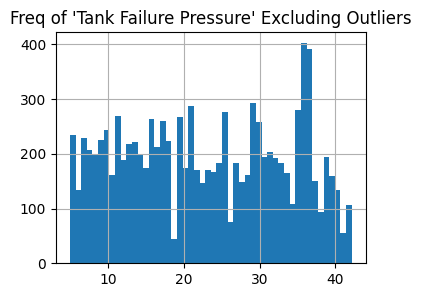



## Smallest 10 values ##


9406    4.92
9422    4.93
9425    4.96
9410    4.97
9417    4.98
9432    5.00
9427    5.00
9421    5.04
5423    5.05
9429    5.06
Name: Tank Failure Pressure (bar), dtype: float64

In [17]:
outlier_df.iloc[outlier_count:]["Tank Failure Pressure (bar)"].hist(bins = 50, figsize = (4,3))
plt.title("Freq of 'Tank Failure Pressure' Excluding Outliers")
plt.show()

print("\n\n## Smallest 10 values ##")
display(outlier_df["Tank Failure Pressure (bar)"].nsmallest(10))

We can see that 1) the outlier values are in the range [1000,5000] and that all the remaining values are roughly between 4 and 40. If we consider for the fact that another popular unit of measurement for pressure, kPa, is 100x the value of bar, these outlier values now make sense and don't appear to be outlier values anymore. Given that these sort of measurement errors are present throughout the data (e.g. use of C instead of K in temperature) and the fact that the values for other variables in these "outlier" data points appear to be reasonable, it appears to be fair to assume that these values are simple recording errors and should be divided by 100, rather than removed.

In [18]:
outlier_df.loc[outlier_df['Tank Failure Pressure (bar)'] > 1000, 'Tank Failure Pressure (bar)'] /= 100

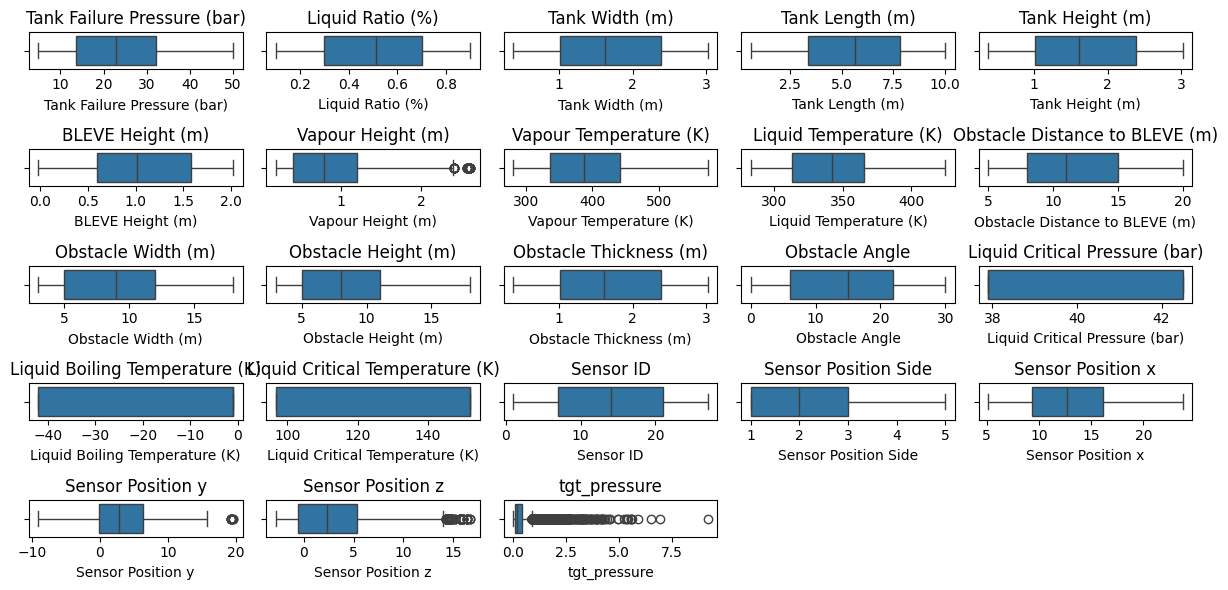

In [19]:

fig, axes = plt.subplots(nrows= 5, ncols=5, figsize=(12, 6))
axes = axes.flatten()

# Plot each boxplot in a separate subplot
for i, column in enumerate(outlier_df.columns):
    sns.boxplot(x=outlier_df[column], ax=axes[i])
    axes[i].set_title(f'{column}')

for j in range(len(outlier_df.columns), len(axes)):
    axes[j].set_visible(False)


plt.tight_layout()
plt.show()

We can see that most columns do not contain outliers in the strict "1.5 * IQR" sense; only "Vapour Height (m)", "Sensor Position y", "Sensor Position z" and "tgt_pressure" do. Below are the histograms for each of these columns.

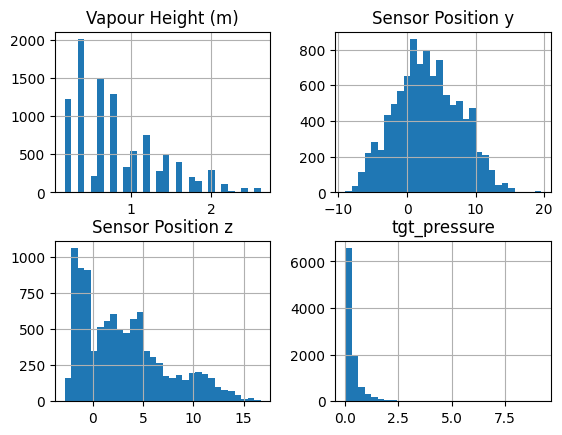

In [20]:
outlier_df[["Vapour Height (m)", "Sensor Position y", "Sensor Position z", "tgt_pressure"]].hist(bins = 30)
plt.show()

In [21]:
outlier_df.query("`Sensor Position y` > 18").sort_index()

Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
5443                         8.90              0.37            1.20   
5444                         8.90              0.37            1.22   
5445                         8.85              0.36            1.22   
5452                         8.88              0.36            1.22   
5453                         8.88              0.37            1.21   
5454                         8.82              0.37            1.19   
5460                         8.99              0.37            1.19   
5461                         8.88              0.37            1.20   
5462                         9.05              0.37            1.18   
5463                         8.82              0.37            1.20   

      Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
5443             3.20             2.21              0.41               1.42   
5444             3.20             2.21              0.39               1.39   
5445             3.20             2.19              0.41               1.41   
5452             3.21             2.21              0.40               1.40   
5453             3.19             2.21              0.42               1.41   
5454             3.19             2.22              0.41               1.42   
5460             3.21             2.22              0.42               1.38   
5461             3.18             2.18              0.41               1.39   
5462             3.21             2.20              0.41               1.39   
5463             3.21             2.20              0.39               1.41   

      Vapour Temperature (K)  Liquid Temperature (K)  \
5443                  352.88                  343.07   
5444                  351.56                  343.28   
5445                  352.50                  342.98   
5452                  351.55                  343.11   
5453                  351.88                  342.87   
5454                  350.64                  343.46   
5460                  351.33                  343.17   
5461                  351.03                  342.86   
5462                  351.57                  343.49   
5463                  351.48                  344.13   

      Obstacle Distance to BLEVE (m)  ...  Obstacle Angle  \
5443                            19.0  ...            30.0   
5444                            19.0  ...            30.0   
5445                            19.0  ...            30.0   
5452                            19.0  ...            30.0   
5453                            19.0  ...            30.0   
5454                            19.0  ...            30.0   
5460                            19.0  ...            30.0   
5461                            19.0  ...            30.0   
5462                            19.0  ...            30.0   
5463                            19.0  ...            30.0   

      Liquid Critical Pressure (bar)  Liquid Boiling Temperature (K)  \
5443                            42.5                           -42.0   
5444                            42.5                           -42.0   
5445                            42.5                           -42.0   
5452                            42.5                           -42.0   
5453                            42.5                           -42.0   
5454                            42.5                           -42.0   
5460                            42.5                           -42.0   
5461                            42.5                           -42.0   
5462                            42.5                           -42.0   
5463                            42.5                           -42.0   

      Liquid Critical Temperature (K)  Sensor ID  Sensor Position Side  \
5443                             96.7        7.0                   1.0   
5444                             96.7        8.0                   1.0   
5445                             96.7        9.0  

We can see that the first 3 variables distributions appear to be normal (as in behaving in a regular fashion, not "normally distributed"). It appears that all the outlier values for "Sensor Position y" come from the same event, so the "outliers" appear to instead be reasonable values that should not be excluded from our data. 

Additionaly, the distributions for "Vapour Height" and "Sensor Position z" appear to be right-skewed, with no values appearing to be "out-of-place", so despite the fact that they may be considered outliers in a traditional sense, they do not warrant removal from the data.

However, the data for tgt_pressure appears to be more prone to outliers (as there is a large gap in the middle and right of the graph). This is looked into further below

<Axes: >

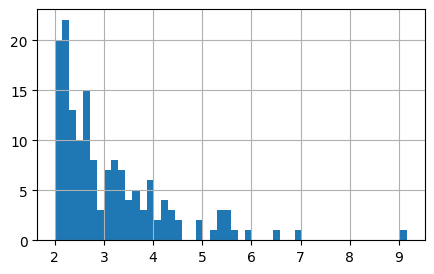

In [22]:
outlier_df.query("`tgt_pressure` > 2")["tgt_pressure"].hist(bins = 50, figsize = (5,3))

In [23]:
outlier_df.sort_values("tgt_pressure", ascending = False).head(10)

Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
6907                        26.15              0.31            3.00   
670                         25.57              0.51            2.22   
667                         25.60              0.51            2.19   
6908                        26.27              0.31            2.98   
3775                        15.51              0.14            0.98   
7822                        18.08              0.21            2.40   
6661                        26.64              0.15            1.19   
6040                        34.13              0.13            1.82   
6664                        26.71              0.15            1.20   
6043                        34.07              0.13            1.81   

      Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
6907             6.58             2.82              0.19               2.01   
670              8.81             2.62              1.41               1.20   
667              8.78             2.61              1.41               1.21   
6908             6.61             2.79              0.21               1.99   
3775             7.99             1.98              0.60               1.82   
7822             4.59             2.59              1.20               2.19   
6661             8.42             3.02              1.01               2.60   
6040             7.61             1.59              0.80               1.42   
6664             8.40             3.00              0.98               2.61   
6043             7.60             1.61              0.78               1.41   

      Vapour Temperature (K)  Liquid Temperature (K)  \
6907                  440.78                  329.90   
670                   456.36                  391.82   
667                   459.64                  391.92   
6908                  440.77                  329.35   
3775                  348.90                  306.30   
7822                  323.97                  340.39   
6661                  532.95                  381.33   
6040                  368.17                  317.01   
6664                  532.93                  381.80   
6043                  368.50                  317.53   

      Obstacle Distance to BLEVE (m)  ...  Obstacle Angle  \
6907                             5.0  ...            13.0   
670                              5.0  ...            18.0   
667                              5.0  ...            18.0   
6908                             5.0  ...            13.0   
3775                             5.0  ...            12.0   
7822                             7.0  ...             7.0   
6661                             8.0  ...            21.0   
6040                             7.0  ...            10.0   
6664                             8.0  ...            21.0   
6043                             7.0  ...            10.0   

      Liquid Critical Pressure (bar)  Liquid Boiling Temperature (K)  \
6907                            42.5                           -42.0   
670                             37.9                            -1.0   
667                             37.9                            -1.0   
6908                            42.5                           -42.0   
3775                            37.9                            -1.0   
7822                            42.5                           -42.0   
6661                            37.9                            -1.0   
6040                            42.5                           -42.0   
6664                            37.9                            -1.0   
6043                            42.5                           -42.0   

      Liquid Critical Temperature (K)  Sensor ID  Sensor Position Side  \
6907                             96.7       13.0                   2.0   
670                             152.0       13.0                   2.0   
667                             152.0       10.0  

In [24]:
for i in [0.9, 0.95, 0.97, 0.98, 0.99, 0.995, 0.9975, 0.999]:
    print(f"{i*100}%: {outlier_df["tgt_pressure"].quantile(i):.4f}")

90.0%: 0.8129
95.0%: 1.2022
97.0%: 1.4823
98.0%: 1.8179
99.0%: 2.4364
99.5%: 3.2794
99.75%: 4.0041
99.9%: 5.3185


Whilst the value of 9.17 from sensor 13 does appear to be quite large, we must consider that it's 1) in the front and middle of the obstacle, and 2) the surrounding 3 sensors (10, 14 and 16) also have abnormally large tgt_pressure values (of 3.22, 5.89 and 2.26 respectively). Additionally, these large values have 1) large tank dimensions and 2) short distances to the explosion source.

As a result, there is thus not considerable doubt that these larger values are erroneous, or influenced by measurement error, errors when entering data, poor sampling etc., and are instead just naturally large values due to their simulation conditions, and so they should not be removed.

<!-- This data doesn't appear to be too unreasonable - they instead appear to be natural variations in the data, notably when the "tank volume" is large - arguably aside from the value of 9.

outlier_df.sort_index(inplace = True)
outlier_df.loc[6904:6910][["Sensor ID", "tgt_pressure"]].T

Whilst the value of 9.17 from sensor 13 does appear to be quite large, we must consider that it's 1) in the front and middle of the obstacle, and 2) the surrounding 3 sensors (10, 14 and 16) also have abnormally large tgt_pressure values (of 3.22, 5.89 and 2.26 respectively). There is thus not considerable doubt that this value is erroneous, or influenced by measurement error, errors when entering data, poor sampling etc. and so it will not be removed. -->

In [815]:
raw_data2 = raw_data1.sort_values("ID").reset_index(drop = True).copy()
raw_data2.loc[raw_data2['Tank Failure Pressure (bar)'] > 1000, 'Tank Failure Pressure (bar)'] /= 100

## Duplicates

In [817]:
# 3: Removing Duplicates (self-explanatory)
display(raw_data2[raw_data2.duplicated(keep=False)].sort_values(by=raw_data2.columns.tolist()))

ID  Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
189     3392.0                        21.09              0.67            1.61   
190     3392.0                        21.09              0.67            1.61   
466     3669.0                        34.87              0.69            2.22   
467     3669.0                        34.87              0.69            2.22   
770     3972.0                        36.87              0.58            2.59   
...        ...                          ...               ...             ...   
9313   12477.0                        31.15              0.28            3.00   
9594   12758.0                        16.44              0.55            0.80   
9595   12758.0                        16.44              0.55            0.80   
10037  13201.0                        18.41              0.57            1.99   
10038  13201.0                        18.41              0.57            1.99   

       Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
189               4.21             1.20              0.99               0.41   
190               4.21             1.20              0.99               0.41   
466               4.20             0.58              1.80               0.19   
467               4.20             0.58              1.80               0.19   
770               3.39             2.62              1.20               1.01   
...                ...              ...               ...                ...   
9313              2.61             2.82              0.79               2.02   
9594              5.58             1.99              1.60               0.82   
9595              5.58             1.99              1.60               0.82   
10037             7.19             1.01              0.21               0.41   
10038             7.19             1.01              0.21               0.41   

       Vapour Temperature (K)  Liquid Temperature (K)  ...     Status  \
189                    410.73                  286.74  ...  Subcooled   
190                    410.73                  286.74  ...  Subcooled   
466                    313.59                  347.11  ...  Subcooled   
467                    313.59                  347.11  ...  Subcooled   
770                    331.10                  287.04  ...  Subcooled   
...                       ...                     ...  ...        ...   
9313                   568.99                  315.17  ...  Subcooled   
9594                   293.54                  285.02  ...  Subcooled   
9595                   293.54                  285.02  ...  Subcooled   
10037                  539.23                  318.86  ...  Subcooled   
10038                  539.23                  318.86  ...  Subcooled   

       Liquid Critical Pressure (bar)  Liquid Boiling Temperature (K)  \
189                              42.5                           -42.0   
190                              42.5                           -42.0   
466                              42.5                           -42.0   
467                              42.5                           -42.0   
770                              42.5                           -42.0   
...                               ...                             ...   
9313                             37.9                            -1.0   
9594                             37.9                            -1.0   
9595                             37.9                            -1.0   
10037                            37.9                            -1.0   
10038                            37.9                            -1.0   

       Liquid Critical Temperature (K)  Sensor ID Sensor Position Side  \
189                               96.7       18.0                  2.0   
190                               96.7       18.0                  2.0   
466                               96.7       25.0                  5.0   
467                         

In [818]:
raw_data3 = raw_data2.drop_duplicates()
print(f"Data dropped: {len(raw_data2) - len(raw_data3)}")

Data dropped: 50


## Data Encoding

In [970]:
# 4.1: Encoding Status Column
raw_data3["Status"].unique()

array(['Superheated', 'Subcooled', 'Subcool', 'subcooled', 'superheated',
       'Subcoled', 'Superheat', 'Saperheated'], dtype=object)

Above, we can see that the value for the "Status" column has many typos in it. Note that there are really only 2 values present, "Superheated" and "Subcooled", all other values are just misspellings of these 2. However, we can see that all values that resemble "Subcooled" contain the word "Sub" or "sub", and all values that resemble "Superheated" contain the word "heat", thus we can fix these incorrect entries as shown below

In [889]:
raw_data3.loc[raw_data3['Status'].str.contains('sub', case=False), 'Status'] = 'Subcooled'
raw_data3.loc[raw_data3['Status'].str.contains('heat', case=False), 'Status'] = 'Superheated'

In [891]:
temp = pd.concat([raw_data3, pd.get_dummies(raw_data3['Status'], drop_first=True).astype(int)], axis=1)
raw_data4 = temp.drop(columns = "Status").rename(columns = {"Superheated": "Superheated_status"})

In [892]:
# 4.2: Encoding Substances
lqd_properties = ["Liquid Critical Pressure (bar)", "Liquid Boiling Temperature (K)", "Liquid Critical Temperature (K)"]
display(raw_data[lqd_properties].dropna().drop_duplicates())

Liquid Critical Pressure (bar)  Liquid Boiling Temperature (K)  \
0                             37.9                            -1.0   
64                            42.5                           -42.0   

    Liquid Critical Temperature (K)  
0                             152.0  
64                             96.7

We can see from the above (as discussed in section 1.2) that there are only 2 unique combinations of critical pressure, boiling temp and critical temp. These are all characteristics that would be unique and fixed for particular substances, suggesting the presence of only 2 unique substances in the data.

We will add a dummy for each of these variables. We can then multiply these values together to identify which substance it is.

In [893]:
dummies = pd.get_dummies(raw_data4['Liquid Critical Pressure (bar)'], drop_first=False)
dummies.columns = ['37.9', '42.5']
dummy_col = dummies['42.5'].rename(f"Liquid Critical Pressure (bar)") * 1
raw_data4 = pd.concat([raw_data4.drop('Liquid Critical Pressure (bar)', axis=1), dummy_col], axis=1)

dummies = pd.get_dummies(raw_data4['Liquid Boiling Temperature (K)'], drop_first=False)
dummies.columns = ['-42', '-1']
dummy_col = dummies['-42'].rename(f"Liquid Boiling Temperature (K)") * 1
raw_data4 = pd.concat([raw_data4.drop('Liquid Boiling Temperature (K)', axis=1), dummy_col], axis=1)

dummies = pd.get_dummies(raw_data4['Liquid Critical Temperature (K)'], drop_first=False)
dummies.columns = ['152.0', '96.7']
dummy_col = dummies['152.0'].rename(f"Liquid Critical Temperature (K)") * 1
raw_data4 = pd.concat([raw_data4.drop('Liquid Critical Temperature (K)', axis=1), dummy_col], axis=1)

lqd_properties = ["Liquid Critical Pressure (bar)", "Liquid Boiling Temperature (K)", "Liquid Critical Temperature (K)"]
raw_data4["substance"] = raw_data4[lqd_properties].prod(axis = 1)

In [894]:
substance_properties = raw_data[lqd_properties].dropna().drop_duplicates()
substance_properties = substance_properties.rename(index = {substance_properties.index[0]: "n-butane", substance_properties.index[1]: "propane"})

In [895]:
substance_properties

Liquid Critical Pressure (bar)  Liquid Boiling Temperature (K)  \
n-butane                            37.9                            -1.0   
propane                             42.5                           -42.0   

          Liquid Critical Temperature (K)  
n-butane                            152.0  
propane                              96.7

## 'Events'

Before we continue, we should establish that the data is grouped into indiviudal explosions. 

Looking at the below example, we can clearly see that the first 4 below belong to the same explosion due to the similarity in values (especially the substance properties), they are just measurements from different sensors - and likewise for the last 4 measurements.

In [897]:
# 4: Adding Events and Removing Noise
raw_data5 = raw_data4.copy()

In [898]:
raw_data5.iloc[33:41]

ID  Tank Failure Pressure (bar)  Liquid Ratio (%)  Tank Width (m)  \
33  3236.0                        30.64              0.81            1.59   
34  3237.0                        30.59              0.81            1.59   
35  3238.0                        30.46              0.80            1.60   
36  3239.0                        30.59              0.80            1.59   
37  3240.0                        24.11              0.66            2.78   
38  3241.0                        24.05              0.66            2.81   
39  3242.0                        24.14              0.66            2.80   
40  3243.0                        23.90              0.65            2.81   

    Tank Length (m)  Tank Height (m)  BLEVE Height (m)  Vapour Height (m)  \
33             4.41             0.80              1.19               0.20   
34             4.39             0.78              1.20               0.18   
35             4.42             0.79              1.20               0.21   
36             4.42             0.79              1.18               0.19   
37             8.38             0.78              1.60               0.19   
38             8.38             0.78              1.58               0.21   
39             8.41             0.81              1.61               0.18   
40             8.40             0.81              1.62               0.20   

    Vapour Temperature (K)  Liquid Temperature (K)  ...  Sensor Position Side  \
33                  363.59                  407.41  ...                   4.0   
34                  363.66                  407.68  ...                   5.0   
35                  363.64                  407.02  ...                   5.0   
36                  364.08                  407.56  ...                   5.0   
37                  461.49                  363.16  ...                   1.0   
38                  461.70                  363.94  ...                   1.0   
39                  462.31                  363.63  ...                   1.0   
40                  461.80                  363.41  ...                   1.0   

    Sensor Position x  Sensor Position y  Sensor Position z  tgt_pressure  \
33              10.30               4.40               12.8      0.102690   
34              10.30               4.65               -1.1      0.149726   
35              10.30               4.65                5.7      0.100412   
36              10.30               4.65               12.5      0.103633   
37              20.05               1.40               -1.5      0.076563   
38              20.05               1.40                1.3      0.077139   
39              20.05               1.40                4.1      0.105216   
40              20.05               4.20               -1.5      0.055952   

    Superheated_status  Liquid Critical Pressure (bar)  \
33                   0                               0   
34                   0                               0   
35                   0                               0   
36                   0                               0   
37                   0                               0   
38                   0                               0   
39                   0                               0   
40                   0                               0   

    Liquid Boiling Temperature (K)  Liquid Critical Temperature (K)  substance  
33                               0                                0          0  
34                               0                                0          0  
35                               0                                0          0  
36                               0                                0          0  
37                               0                                0          0  
38                               0                                0          0  
39                               0                                0          0  
40                       

It however makes no sense that values which should be constant (e.g. "tank width") are different between measurements. This would be artificially induced noise that will be removed for the sake of consistency. This noise also leads to nonsensical values - for example, where the "Vapour Height" (the height of the vapour in the tank) exceeds the "Tank Height" as can be seen below.

In [899]:
raw_data5.query("`Tank Height (m)` < `Vapour Height (m)`")[["Vapour Height (m)","Tank Height (m)"]].head()

Vapour Height (m)  Tank Height (m)
1367               0.82             0.80
1369               0.82             0.81
1375               0.81             0.78
1378               0.81             0.79
1379               0.82             0.79

To deal with this, we'll separate the data points into their separate events by adding an "event_num". We'll then set the value of appropriate parameters to the median of all the different values for that event - we'll avoid using mean as this is prone to outliers.

In [974]:
# Generate event_nums
event_num = 1
prev_id = raw_data5["Sensor ID"][0]
prev_trial = raw_data5["ID"][0]

event_nums = []

for index, row in raw_data5.iterrows():
    curr_id = row["Sensor ID"]
    curr_trial = row["ID"]

    # new event if sensor_id decreases (i.e. goes from 26, 27 --> 1, 2, ...) OR the ID value is more than 27 larger than the previous value
    if (curr_id < prev_id) or (curr_trial > prev_trial + 27): 
        event_num += 1 
    
    event_nums.append(event_num)
    prev_id = curr_id
    prev_trial = curr_trial

raw_data5.loc[:,"event_num"] = event_nums

We will now remove the noise from the columns which should be the same across events

In [975]:
changing_cols = ['ID', 
                 'Sensor ID', 
                 'Sensor Position Side', 
                 'Sensor Position x', 
                 'Sensor Position y', 
                 'Sensor Position z', 
                 'tgt_pressure', 
                 'event_num']
constant_cols = raw_data5.columns[~raw_data5.columns.isin(changing_cols)]
event_medians = raw_data5.groupby('event_num')[constant_cols].median().reset_index()

# Merge aggregated data back to the original DataFrame based on 'event_num'
raw_data6 = pd.merge(raw_data5[changing_cols],
                       event_medians,
                       on='event_num',
                     )

raw_data6 = raw_data6[raw_data5.columns]

Whilst noise might have been added to a few columns in the dataframe, we saw above that this was not present in the liquid's properties and thus the value for this should be constant for an event - if these values change, it implies that there is a different substance being used, which implies greater issues with the data. We will check for this below.

In [976]:
check_cols = [
    "Liquid Critical Pressure (bar)",
    "Liquid Boiling Temperature (K)",
    "Liquid Critical Temperature (K)",
    "substance"
]

inconsistent_trials = []
for event_num, group_data in raw_data5.groupby('event_num'):
    group_values = group_data[check_cols].values
    
    if not all(all(val == 1 for val in row) or all(val == 0 for val in row) for row in group_values):
        inconsistent_trials.append(event_num)
        # mode_values = group_data[check_cols].mode(axis=1).iloc[:, 0]
        # raw_data6.loc[group_data.index, check_cols] = mode_values

print(f"Event_num values with inconsistent values:\n{inconsistent_trials}")

Event_num values with inconsistent values:
[16, 27, 28, 78, 92, 95, 99, 100, 109, 110, 188, 200, 203, 213, 216, 218, 222, 225, 243, 261, 269, 280, 287, 336, 341]


Let's analyse an example below

In [977]:
display(raw_data5.query("event_num == 16 and substance == 0")[check_cols + ["ID"]],
        raw_data.query("ID == 3609")[check_cols[:3]])

Liquid Critical Pressure (bar)  Liquid Boiling Temperature (K)  \
407                               1                               0   

     Liquid Critical Temperature (K)  substance      ID  
407                                1          0  3609.0

Liquid Critical Pressure (bar)  Liquid Boiling Temperature (K)  \
406                            42.5                             NaN   

     Liquid Critical Temperature (K)  
406                             96.7

We can see that the anomaly comes from the presence of a NaN in the data. This was filled in with the median, which is the value for one of the materials. Whilst this works for rows in which this is the correct material, rows in which this is not the case (like above) need to be fixed. 

Since we only ever replaced 1 NaN at a time, we can force all 3 values to be the most common number out of the 3 (i.e. the mode). However, we could also do this by looking at each individual event separately, and take the median of each column and make that the new value, which we have actually already done above when trying to de-noise our data by taking the mean of each event. 

This approach would fix scenarios where 1 NaN has been incorrectly replaced within an event. In the extremely unlikely scenario that that column had a majority of NaNs for that given event (unlikely considering that the maximum number of NaNs for any of these 3 columns was 30), the other 2 columns would be correct and thus this would be marked as an inconsistent event. We can see below that this is not the case.

In [978]:
inconsistent_trials = []
for event_num, group_data in raw_data6.groupby('event_num'):
    group_values = group_data[check_cols].values
    
    if not all(all(val == 1 for val in row) or all(val == 0 for val in row) for row in group_values):
        inconsistent_trials.append(event_num)

print(f"Event_num values with inconsistent values:\n{inconsistent_trials}")

Event_num values with inconsistent values:
[]


## Incorrect Values

### Negative and 0 Values

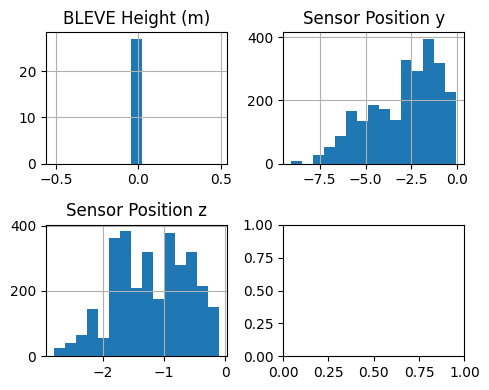

In [979]:
# 3.1: Removing Negative and 0 Values
n_cols = 2
n_rows = 2
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2))

i = 0
for var in raw_data6.columns:
    if var == "Status":
        continue
    temp = raw_data6[raw_data6[var] < 0]
    
    if not temp.empty:
        ax = axs[i//n_cols, i%n_cols]
        temp[var].hist(bins=15, ax = ax)
        ax.set_title(f'{var}')
        i += 1

plt.tight_layout()
plt.show()

Note that the "BLEVE Height (m)" is "the distance of the tank to the ground (in meter)" [sic]. After confirming with the source of the data that this cannot be negative, we should clip this value to 0. Note though that this will be done later, as explained below

Also note that "Liquid Boiling Temperature" is in Kelvin and also had negative values, which should be impossible - it hasn't shown up as we have encoded this value.

In [980]:
raw_data6["BLEVE Height (m)"] = raw_data6["BLEVE Height (m)"].clip(lower = 0)

### Other

The height of vapour in the tank should not exceed the height of the tank itself. Below are events in which this occur.

In [981]:
raw_data6.loc[raw_data6["Tank Height (m)"] < raw_data6["Vapour Height (m)"]][["Tank Height (m)","Vapour Height (m)", "Liquid Ratio (%)"]].drop_duplicates()

Tank Height (m)  Vapour Height (m)  Liquid Ratio (%)
3434             0.59                0.6              0.14
6752             0.39                0.4              0.19

In [982]:
raw_data7 = raw_data6.query("`Tank Height (m)` >= `Vapour Height (m)`")

## Major Edits

We will split the data into train, validation and test sets before analysing the data (so we can test our hypotheses locally before submitting them for assessment). However, before we do this, we'll do perform any changes that apply to all datasets here (so we don't have to add them to each dataset separately). This mainly includes renaming the columns to something more friendly for analysis (i.e. snake_case), as well as adding features that we'll explore later.

### Variable Renaming

In [921]:
renamed_cols = [
    "ID",
    "failure_pressure",
    "liquid_pct",
    "tank_w",
    "tank_l",
    "tank_h",
    "BLEVE_h",
    "vapour_height",
    "vapour_temp",
    "liquid_temp",
    "obstacle_dist",
    "obstacle_w",
    "obstacle_h",
    "obstacle_thk",
    "obstacle_angle",
    "sensor_id",
    "sensor_side",
    "sensor_x",
    "sensor_y",
    "sensor_z",
    "tgt_pressure",
    "superheated_status",
    "lqd_crit_pressure",
    "lqd_boil_temp",
    "lqd_crit_temp",
    "substance",
    "event_num",
    "tank_volume",
    "net_sensor_dist"
]

In [1010]:
dict_names = dict(zip(raw_data7.columns, renamed_cols))

raw_data8 = raw_data7.rename(columns = dict_names)

### Feature Addition

Immediately we can see that many of our variables relate to each other
* E.g. we have tank height, length and width, which suggest that we should create a variable for the tank volume.
* Also, we have the location of sensors. This is quite important, but we can group sensors by "front", "back" and "side" (rather than looking at them individually)
* Furthermore, we can try convert the sensor's position into a distance metric

In [1011]:
sensor_vars = ["sensor_x", "sensor_y", "net_z"]
raw_data8["net_z"] = raw_data8["sensor_z"] - raw_data8["BLEVE_h"]
raw_data8["net_sensor_dist"] = np.linalg.norm(raw_data8[sensor_vars], axis=1)
sensor_vars.append("sensor_z")
raw_data8.drop(columns = sensor_vars, inplace = True)

# raw_data8["sensor_location"] = raw_data8["sensor_side"].map({1: 1, 2: 2, 3: 3, 4: 3, 5: 3}) # changes 4 and 5 (both sides) to 3 (1 = back, 2 = front, 3 = sides)

tank_axis = ["tank_w", "tank_h", "tank_l"]
raw_data8["tank_volume"] = raw_data8[tank_axis].prod(axis = 1)
raw_data8["liquid_vol"] = raw_data8["tank_volume"] * raw_data8["liquid_pct"]
raw_data8["vapor_vol"] = raw_data8["tank_volume"] * (1 - raw_data8["liquid_pct"])

#### Liquid Correction Method

In [1012]:
propane_link = "https://raw.githubusercontent.com/harvey-py/COMP3010/main/Assignment/Data/propane_data.txt"
butane_link = "https://raw.githubusercontent.com/harvey-py/COMP3010/main/Assignment/Data/butane_data.txt"

propane_props = pd.read_csv(propane_link, sep = "\t").query("Phase == 'liquid'").dropna()[["Temperature (K)", "Pressure (bar)", "Cp (J/mol*K)"]]
butane_props = pd.read_csv(butane_link, sep = "\t").query("Phase == 'liquid'").dropna()[["Temperature (K)", "Pressure (bar)", "Cp (J/mol*K)"]]

butane_grpd = butane_props.groupby("Temperature (K)")["Cp (J/mol*K)"].median()
propane_grpd = propane_props.groupby("Temperature (K)")["Cp (J/mol*K)"].median()

cp_range = butane_grpd.max() - butane_grpd.min()
temp_range = butane_grpd.idxmax() - butane_grpd.idxmin()
ref_cp_butane = butane_grpd.min()
ref_t_butane = butane_grpd.idxmin()
m_butane = cp_range / temp_range

cp_range = propane_grpd.max() - propane_grpd.min()
temp_range = propane_grpd.idxmax() - propane_grpd.idxmin()
ref_cp_propane = propane_grpd.min()
ref_t_propane = propane_grpd.idxmin()
m_propane = cp_range / temp_range


def cp_calc(substance, temp):
    if substance == 0:
        m = m_butane
        min_temp = ref_t_butane
        min_cp = ref_cp_butane
    elif substance == 1:
        m = m_propane
        min_temp = ref_t_propane
        min_cp = ref_cp_propane
    else:
        print(substance)
        raise ValueError("Invalid substance specified")
    

    return round(m * (temp - min_temp) + min_cp, 4)

raw_data8["cp"] = raw_data8.apply(lambda row: cp_calc(row["substance"], row["liquid_temp"]), axis=1)

In [1013]:
# Using the NIST database
# cp = pd.DataFrame.from_dict({"n-butane": 130, "propane": 100}, orient = "index", columns = ["cp"])
substance_dict = substance_properties.copy()
substance_dict.columns = ["pc", "tb", "tc"]

In [1014]:
# t0 = temp at explosion
# tc = critical temp
# tb = boiling temp
# pc = critical pressure

def Hv(superheated, substance_val, liquid_temp, cp, substance_dict = substance_dict):
    # if substance not in ["propane", "n-butane"]:
    #     raise ValueError("Invalid Substance Specified")

    if substance_val == 0:
        substance = "n-butane"
    if substance_val == 1:
        substance = "propane"

    # display(substance_dict)
    lookup = substance_dict.loc[substance]
    
    t0 = liquid_temp
    tb = lookup["tb"] + 273.15
    tc = lookup["tc"] + 273.15
    pc = lookup["pc"]
    
    num = 1.092 * 8.3145 * tb * (np.log(pc) - 1.013)
    denom = 0.93 - tb / tc
    frac = (tc - t0) / (tc - tb)
    
    return (num / denom * frac ** 0.383), frac, substance, lookup, superheated, cp


def f_frac(Hv_output):
    Hv, frac, substance, lookup, superheated, cp = Hv_output

    if superheated == 0:
        return 0
    
    tc = lookup["tc"]
    tb = lookup["tb"]
    
    term = -2.63 * cp / Hv * (tc - tb) * (1 - frac ** 0.38)
    return (1 - np.exp(term))



In [1015]:
raw_data8["f"] = raw_data8.apply(lambda row: f_frac(Hv(row["superheated_status"],
                                             row["substance"], 
                                             row["liquid_temp"],
                                             row["cp"]),), axis=1)

In [1016]:
raw_data8["net_vapor"] = (raw_data8["liquid_vol"]) * raw_data8["f"] + raw_data8["vapor_vol"]

In [1017]:
gamma = raw_data8["substance"].apply(lambda x: 1.18 if x == 0 else 1.13)
raw_data8["vapor_energy"] = 10**2 * (raw_data8["failure_pressure"] * raw_data8["net_vapor"] / (gamma - 1)) * (1 - (1.01325/raw_data8["failure_pressure"])**(gamma-1)/gamma)

#### Density

In [1018]:
butane_density_link = "https://raw.githubusercontent.com/harvey-py/COMP3010/main/Assignment/Data/butane_data_all5.txt"
propane_density_link = "https://raw.githubusercontent.com/harvey-py/COMP3010/main/Assignment/Data/propane_data_all5.txt"
butane_density_link2 = "https://raw.githubusercontent.com/harvey-py/COMP3010/main/Assignment/Data/butane_data_all5_v3.txt"
propane_density_link2 = "https://raw.githubusercontent.com/harvey-py/COMP3010/main/Assignment/Data/propane_data_all5_v2.txt"

propane_props2 = pd.read_csv(propane_density_link, sep = "\t").dropna()[["Temperature (K)", "Pressure (bar)", "Density (mol/l)", "Phase"]].query("`Temperature (K)` % 5 == 0")
butane_props2 = pd.read_csv(butane_density_link, sep = "\t").dropna()[["Temperature (K)", "Pressure (bar)", "Density (mol/l)", "Phase"]].query("`Temperature (K)` % 5 == 0")
propane_props3 = pd.read_csv(propane_density_link2, sep = "\t").dropna()[["Temperature (K)", "Pressure (bar)", "Density (mol/l)", "Phase"]].query("`Temperature (K)` % 5 == 0")
butane_props3 = pd.read_csv(butane_density_link2, sep = "\t").dropna()[["Temperature (K)", "Pressure (bar)", "Density (mol/l)", "Phase"]].query("`Temperature (K)` % 5 == 0")

propane_density_temp = pd.concat([propane_props2, propane_props3]).sort_values(["Temperature (K)", "Pressure (bar)"])
butane_density_temp = pd.concat([butane_props2, butane_props3]).sort_values(["Temperature (K)", "Pressure (bar)"])

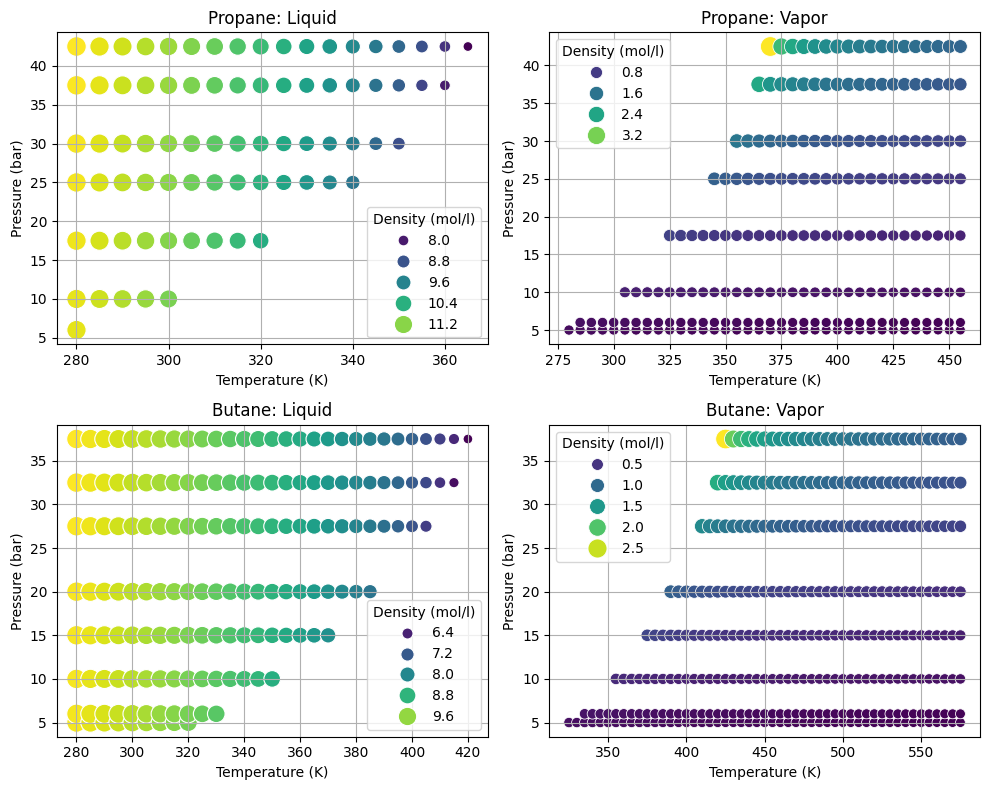

<Figure size 640x480 with 0 Axes>

In [1019]:
# Create figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

# Create scatter plot for butane
sns.scatterplot(data=propane_density_temp.query("Phase == 'liquid'"), x="Temperature (K)", y="Pressure (bar)", hue="Density (mol/l)", palette="viridis", size="Density (mol/l)", sizes=(50, 200), ax=axes[0])
axes[0].set_title("Propane: Liquid")
axes[0].set_xlabel("Temperature (K)")
axes[0].set_ylabel("Pressure (bar)")
axes[0].legend(title="Density (mol/l)")
axes[0].grid(True)

# Create scatter plot for propane
sns.scatterplot(data=propane_density_temp.query("Phase == 'vapor'"), x="Temperature (K)", y="Pressure (bar)", hue="Density (mol/l)", palette="viridis", size="Density (mol/l)", sizes=(50, 200), ax=axes[1])
axes[1].set_title("Propane: Vapor")
axes[1].set_xlabel("Temperature (K)")
axes[1].set_ylabel("Pressure (bar)")
axes[1].legend(title="Density (mol/l)")
axes[1].grid(True)


# Create scatter plot for butane
sns.scatterplot(data=butane_density_temp.query("Phase == 'liquid'"), x="Temperature (K)", y="Pressure (bar)", hue="Density (mol/l)", palette="viridis", size="Density (mol/l)", sizes=(50, 200), ax=axes[2])
axes[2].set_title("Butane: Liquid")
axes[2].set_xlabel("Temperature (K)")
axes[2].set_ylabel("Pressure (bar)")
axes[2].legend(title="Density (mol/l)")
axes[2].grid(True)

# Create scatter plot for propane
sns.scatterplot(data=butane_density_temp.query("Phase == 'vapor'"), x="Temperature (K)", y="Pressure (bar)", hue="Density (mol/l)", palette="viridis", size="Density (mol/l)", sizes=(50, 200), ax=axes[3])
axes[3].set_title("Butane: Vapor")
axes[3].set_xlabel("Temperature (K)")
axes[3].set_ylabel("Pressure (bar)")
axes[3].legend(title="Density (mol/l)")
axes[3].grid(True)

plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

In [1020]:
def predict_vapor_density_275K(data):
    vapor_data = data[data['Phase'] == 'vapor']
    unique_pressures = vapor_data['Pressure (bar)'].unique()
    vapor_models = {}

    for pressure in unique_pressures:
        pressure_data = vapor_data[vapor_data['Pressure (bar)'] == pressure].sort_values("Temperature (K)").head(10)
        X = pressure_data[['Temperature (K)']].values
        y = pressure_data['Density (mol/l)'].values
        vapor_models[pressure] = LinearRegression().fit(X, y)

    predictions = []
    for pressure, model in vapor_models.items():
        input_data = [[275.0]]
        predicted_density = model.predict(input_data)[0]
        predictions.append((pressure, predicted_density))

    density_275 = pd.DataFrame(predictions, columns=['Pressure (bar)', 'Density (mol/l)'])
    density_275["Temperature (K)"] = 275
    density_275["Phase"] = "vapor"

    return density_275

In [1021]:
propane_vapor_275 = predict_vapor_density_275K(propane_density_temp)
butane_vapor_275 = predict_vapor_density_275K(butane_density_temp)

propane_density = pd.concat([propane_density_temp, propane_vapor_275]).sort_values(["Temperature (K)", "Pressure (bar)"]).reset_index(drop = True)
butane_density = pd.concat([butane_density_temp, butane_vapor_275]).sort_values(["Temperature (K)", "Pressure (bar)"]).reset_index(drop = True)

In [1022]:
def build_density_models(data):
    models = {}
    substances = data['substance'].unique()
    
    for substance in substances:
        substance_data = data[data['substance'] == substance]
        
        liquid_model = LinearRegression()
        vapor_model = LinearRegression()
        
        liquid_X = substance_data[substance_data['Phase'] == 'liquid'][['Temperature (K)', 'Pressure (bar)']].values
        liquid_y = substance_data[substance_data['Phase'] == 'liquid']['Density (mol/l)'].values
        liquid_model.fit(liquid_X, liquid_y)

        points = substance_data.query("Phase == 'vapor'")[['Temperature (K)', 'Pressure (bar)']].values
        values = substance_data.query("Phase == 'vapor'")['Density (mol/l)'].values
        
        models[substance] = {'liquid': liquid_model, 'vapor': (points, values)}
        
    return models

def predict_densities(data, models):
    for i, row in data.iterrows():
        substance = row['substance']
        pressure = row['failure_pressure']
        liquid_temp = row['liquid_temp']
        vapor_temp = row['vapour_temp']
        
        liquid_input = [[liquid_temp, pressure]]
        vapor_input = [[vapor_temp, pressure]]
        
        liquid_density = models[substance]['liquid'].predict(liquid_input)[0]

        points, values = models[substance]["vapor"]
        vapour_density = griddata(points, values, (vapor_temp, pressure), method='linear')
        
        data.at[i, 'density_liquid'] = liquid_density
        data.at[i, 'density_vapour'] = vapour_density
        
    return data

In [1023]:
temp = raw_data8.copy()

In [1024]:
combined_data = pd.concat([butane_density.assign(substance=0), propane_density.assign(substance=1)], ignore_index=True)
temp_models = build_density_models(combined_data)
temp2 = predict_densities(temp, temp_models)
temp2["density_ratio"] = temp2["density_liquid"] / temp2["density_vapour"]

In [1101]:
temp2["1/dist_sq"] = temp2["net_sensor_dist"] ** -2

In [1025]:
# temp2["net_vapor"] = temp2["liquid_vol"] * temp2["f"] * temp2["density_ratio"] + temp2["vapor_vol"]
gamma = temp2["substance"].apply(lambda x: 1.18 if x == 0 else 1.13)
temp2["vapor_energy"] = 10**2 * (temp2["failure_pressure"] * temp2["vapor_vol"] / (gamma - 1)) * (1 - (1.01325/temp2["failure_pressure"])**(gamma-1)/gamma)
# temp2["net_vapor_energy"] = 10**2 * (temp2["failure_pressure"] * temp2["net_vapor"] / (gamma - 1)) * (1 - (1.01325/temp2["failure_pressure"])**(gamma-1)/gamma)

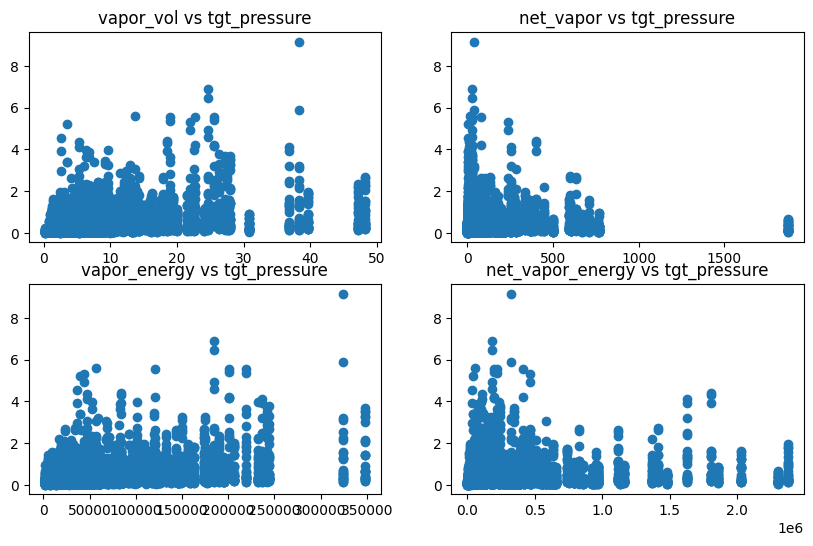

In [1026]:
fig, ax = plt.subplots(2, 2, figsize = (10, 6))
ax = ax.flatten()

for i, var in enumerate(["vapor_vol", "net_vapor", "vapor_energy", "net_vapor_energy"]):
    ax[i].scatter(temp2[var], temp2["tgt_pressure"])
    ax[i].set_title(f"{var} vs tgt_pressure")

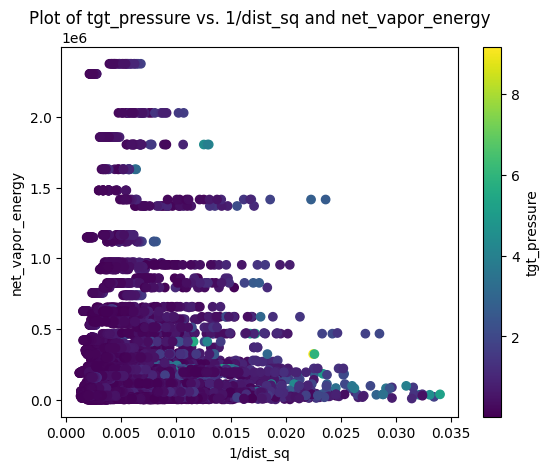

In [1107]:
plt.scatter(data = temp2, x = "1/dist_sq", y = "net_vapor_energy", c = "tgt_pressure")
plt.xlabel("1/dist_sq")
plt.ylabel("net_vapor_energy")
plt.title("Plot of tgt_pressure vs. 1/dist_sq and net_vapor_energy")
plt.colorbar(label="tgt_pressure")
plt.show()

## Transformation Function

In [1211]:
def transformation_wrapper(df):
    df.rename(columns = {"Target Pressure (bar)": "tgt_pressure"}, inplace = True)
    
    df = df.apply(replace_single_nan, axis=1)
    df.dropna(inplace = True)
    
    # Outlier removal
    df = df.sort_values("ID").reset_index(drop = True)
    df.loc[df['Tank Failure Pressure (bar)'] > 1000, 'Tank Failure Pressure (bar)'] /= 100

    # Encoding
    df.loc[df['Status'].str.contains('sub|cool', case=False), 'Status'] = 'Subcooled'
    df.loc[df['Status'].str.contains('super|heat', case=False), 'Status'] = 'Superheated'

    temp = pd.concat([df, pd.get_dummies(df['Status'], drop_first=True).astype(int)], axis=1)
    del df
    df = temp.drop(columns = "Status").rename(columns = {"Superheated": "Superheated_status"})
    del temp

    dummies = pd.get_dummies(df['Liquid Critical Pressure (bar)'], drop_first=False)
    dummies.columns = ['37.9', '42.5']
    dummy_col = dummies['42.5'].rename(f"Liquid Critical Pressure (bar)") * 1
    df = pd.concat([df.drop('Liquid Critical Pressure (bar)', axis=1), dummy_col], axis=1)
    del dummies
    del dummy_col
    
    dummies = pd.get_dummies(df['Liquid Boiling Temperature (K)'], drop_first=False)
    dummies.columns = ['-42', '-1']
    dummy_col = dummies['-42'].rename(f"Liquid Boiling Temperature (K)") * 1
    df = pd.concat([df.drop('Liquid Boiling Temperature (K)', axis=1), dummy_col], axis=1)
    del dummies
    del dummy_col
    
    dummies = pd.get_dummies(df['Liquid Critical Temperature (K)'], drop_first=False)
    dummies.columns = ['152.0', '96.7']
    dummy_col = dummies['152.0'].rename(f"Liquid Critical Temperature (K)") * 1
    df = pd.concat([df.drop('Liquid Critical Temperature (K)', axis=1), dummy_col], axis=1)
    del dummies
    del dummy_col

    # Creating a lookup for the properties of each substance (there are only 2 distinct substance present; we will denote them 0 and 1). This table will allow us to view their properties later
    substance_properties = df[["Liquid Critical Pressure (bar)", "Liquid Boiling Temperature (K)", "Liquid Critical Temperature (K)"]].drop_duplicates()
    substance_properties = substance_properties.rename(index = {substance_properties.index[0]: "n-butane", substance_properties.index[1]: "propane"})

    #Setting up event_num
    event_num = 1
    prev_id = df["Sensor ID"][0]
    prev_trial = df["ID"][0]
    
    event_nums = []
    
    for index, row in df.iterrows():
        curr_id = row["Sensor ID"]
        curr_trial = row["ID"]
        if (curr_id < prev_id) or (curr_trial > prev_trial + 27):
            event_num += 1 
        
        event_nums.append(event_num)
        prev_id = curr_id
        prev_trial = curr_trial
    
    df.loc[:,"event_num"] = event_nums

    changing_cols = ['ID', 
                 'Sensor ID', 
                 'Sensor Position Side', 
                 'Sensor Position x', 
                 'Sensor Position y', 
                 'Sensor Position z', 
                 'tgt_pressure', 
                 'event_num']
    df_subset = df.copy()
    constant_cols = df.columns[~df.columns.isin(changing_cols)]
    event_medians = df.groupby('event_num')[constant_cols].median().reset_index()
    
    # Merge aggregated data back to the original DataFrame based on 'event_num'
    try:
        df = pd.merge(df[changing_cols],
                           event_medians,
                           on='event_num',
                         )
    except KeyError:
        changing_cols.remove("tgt_pressure")
        df = pd.merge(df[changing_cols],
                           event_medians,
                           on='event_num',
                         )
    df = df[df_subset.columns]
    del df_subset

    df["BLEVE Height (m)"] = df["BLEVE Height (m)"].clip(lower = 0)
    df = df.query("`Tank Height (m)` >= `Vapour Height (m)`")
    final_df = df.drop_duplicates()
    del df

    # Renaming columns
    renamed_cols = [
        "ID",
        "failure_pressure",
        "liquid_pct",
        "tank_w",
        "tank_l",
        "tank_h",
        "BLEVE_h",
        "vapour_height",
        "vapour_temp",
        "liquid_temp",
        "obstacle_dist",
        "obstacle_w",
        "obstacle_h",
        "obstacle_thk",
        "obstacle_angle",
        "sensor_id",
        "sensor_side",
        "sensor_x",
        "sensor_y",
        "sensor_z",
        "tgt_pressure",
        "superheated_status",
        "lqd_crit_pressure",
        "lqd_boil_temp",
        "lqd_crit_temp",
        "event_num",
        "tank_volume",
        "1/dist_sq"
    ]

    if len(final_df.columns) == 25:
        renamed_cols.remove("tgt_pressure")
    
    dict_names = dict(zip(final_df.columns, renamed_cols))
    
    df = final_df.rename(columns = dict_names)
    del final_df

    # Feature Engineering
    tank_axis = ["tank_w", "tank_h", "tank_l"]
    df["tank_volume"] = df[tank_axis].prod(axis = 1)
   
    # df["sensor_location"] = df["sensor_side"].map({1: 1, 2: 2, 3: 3, 4: 3, 5: 3}) # changes 4 and 5 (both sides) to 3 (1 = back, 2 = front, 3 = sides)
    
    sensor_vars = ["sensor_x", "sensor_y", "net_z"]
    df["net_z"] = df["sensor_z"] - df["BLEVE_h"]

    # Can we do net_x, net_y?

    df["obstacle_angle"] = np.cos(df["obstacle_angle"] * np.pi / 180)
    
    df["1/dist"] = np.linalg.norm(df[sensor_vars], axis=1) ** -1
    df["1/dist_sq"] = df["1/dist"] ** 2
    df["1/dist_cub"] = df["1/dist"] ** 3
    df["1/dist_qrt"] = df["1/dist"] ** 4
    
    sensor_vars.append("sensor_z")
    df.drop(columns = sensor_vars, inplace = True)
    
    lqd_properties = ["lqd_crit_pressure", "lqd_boil_temp", "lqd_crit_temp"]
    df["substance"] = df[lqd_properties].prod(axis = 1)
    df.drop(columns = lqd_properties, inplace = True)

    df["cp"] = df.apply(lambda row: cp_calc(row["substance"], row["liquid_temp"]), axis=1)
    df["f"] = df.apply(lambda row: f_frac(Hv(row["superheated_status"],
                                                 row["substance"], 
                                                 row["liquid_temp"],
                                                 row["cp"]),), axis=1)
    
    df["vapor_vol"] = df["tank_volume"] * (1 - df["liquid_pct"])
    gamma = df["substance"].apply(lambda x: 1.18 if x == 0 else 1.13)
    df["vapor_energy"] = 10**2 * (df["failure_pressure"] * df["vapor_vol"] / (gamma - 1)) * (1 - (1.01325/df["failure_pressure"])**(gamma-1)/gamma)
    
    # df["BLEVE_vapor"] = (df["tank_volume"] - df["vapor_vol"]) * df["f"]
    # df["net_vapor"] = df["BLEVE_vapor"] + df["vapor_vol"]    
    # df['SLT_excess'] = np.where(df['substance'] == 0, df['liquid_temp'] - 371, df['liquid_temp'] - 321).clip(min = 0)
    
    # df["net_vapor_energy"] = 10**2 * (df["failure_pressure"] * df["net_vapor"] / (gamma - 1)) * (1 - (1.01325/df["failure_pressure"])**(gamma-1)/gamma)
    
    return df

In [1033]:
def rescale_data(df, train = True, stats = []):
    unscaled_cols = [col for col in df.columns if col not in ["tgt_pressure", 
                                                              "ID", 
                                                              "sensor_id", 
                                                              "sensor_side", 
                                                              "superheated_status", 
                                                              "event_num", 
                                                              "substance"]]#, "obstacle_angle"]]

    if train:
        means = df[unscaled_cols].mean()
        stds = df[unscaled_cols].std()

        qt = sklearn.preprocessing.QuantileTransformer(output_distribution="normal")
        df["tgt_pressure"] = qt.fit_transform(df[["tgt_pressure"]])

        df[unscaled_cols] = (df[unscaled_cols] - means) / stds
        
        x = df.drop(columns = "tgt_pressure").sort_values("ID")
        y = df["tgt_pressure"][x.index]

        return x, y, qt, means, stds

    else:
        means, stds = stats[0], stats[1]
        df[unscaled_cols] = (df[unscaled_cols] - means) / stds
        return df.sort_values("ID")


In [1034]:
def scale_back(y, index, qt):
    pred_df = pd.DataFrame(y).values
    transform_back = qt.inverse_transform(pred_df)
    output_series = pd.Series(np.ravel(transform_back), index = index)
    
    return output_series    

In [344]:
# def rescale_data(df, train = True, stats = []):
#     unscaled_cols = [col for col in df.columns if col not in ["tgt_pressure", 
#                                                               "ID", 
#                                                               "sensor_id", 
#                                                               "sensor_side", 
#                                                               "superheated_status", 
#                                                               "event_num", 
#                                                               "substance"]]#, "obstacle_angle"]]

#     if train:
#         x = df.drop(columns = "tgt_pressure")
#         y = df["tgt_pressure"]
        
#         df_transform = df.copy() #df.loc[~df.index.isin(X_test.index)]
#         means = df_transform[unscaled_cols].mean()
#         stds = df_transform[unscaled_cols].std()
        
#         df_transform[unscaled_cols] = (df_transform[unscaled_cols] - means) / stds

#         qt = sklearn.preprocessing.QuantileTransformer(output_distribution="normal")
#         df_transform["tgt_pressure"] = qt.fit_transform(df_transform[["tgt_pressure"]])

#         # train = df_transform.loc[X_train.index].sort_index()
#         # X_train = train.drop(columns = "tgt_pressure")
#         # y_train = train["tgt_pressure"]
        
#         # val = df_transform.loc[X_val.index].sort_index()
#         # X_val = val.drop(columns = "tgt_pressure")
#         # y_val = val["tgt_pressure"]
        
#         # X_test[unscaled_cols] = (X_test[unscaled_cols] - means) / stds
#         # y_test = pd.Series(np.ravel(qt.transform(pd.DataFrame(y_test)))).sort_index()
    
#         return df_transform, qt, means, stds # X_train.sort_index(), X_val.sort_index(), X_test.sort_index(), y_train, y_val, y_test, qt, means, stds

#     else:
#         means, stds = stats[0], stats[1]
#         df[unscaled_cols] = (df[unscaled_cols] - means) / stds
#         return df


In [1255]:
x, y, qt, means, stds = rescale_data(transformation_wrapper(raw_data))
ext_x = rescale_data(transformation_wrapper(raw_test_data), train = False, stats = [means, stds])

train, temp_set = train_test_split(raw_data, test_size = 0.2, random_state = 42)
train.sort_values("ID",inplace = True)
temp_set.sort_values("ID",inplace = True)

X_train, y_train, qt, means, stds = rescale_data(transformation_wrapper(train))
temp = rescale_data(transformation_wrapper(temp_set), train = False, stats = [means, stds])
ext_x = rescale_data(transformation_wrapper(raw_test_data), train = False, stats = [means, stds])

temp_X = temp.drop(columns = "tgt_pressure")
temp_y = temp["tgt_pressure"]

X_val, X_test, y_val, y_test = train_test_split(temp_X, temp_y, test_size = 0.4, random_state = 42)

In [944]:
def mape_calc(y_tgt, y_pred):
    return np.mean(np.abs(1 - y_pred / y_tgt))

def adj_r2(y_tgt, y_pred, X):
    R2 = r2_score(y_tgt, y_pred)
    n = len(y_tgt)
    p = X.shape[1]
    adj_r2 = 1- (1-R2) * (n-1)/(n-p-1)
    return adj_r2

# Random Forest

In [1343]:
processed_data = transformation_wrapper(raw_data)
ext_x = transformation_wrapper(raw_test_data)

X = processed_data.drop(columns = "tgt_pressure")
y = processed_data["tgt_pressure"]

X_train, temp_X, y_train, temp_y = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(temp_X, temp_y, test_size = 0.4, random_state = 42)

In [1215]:
def rf_objective(trial, rf_params, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_categorical("n_estimators", rf_params["n_estimators"])
    max_depth = trial.suggest_int("max_depth", rf_params["max_depth"][0], rf_params["max_depth"][1])
    min_samples_split = trial.suggest_int("min_samples_split", rf_params["min_samples_split"][0], rf_params["min_samples_split"][1])
    min_samples_leaf = trial.suggest_int("min_samples_leaf", rf_params["min_samples_leaf"][0], rf_params["min_samples_leaf"][1])

    rf_model = RandomForestRegressor(n_estimators = n_estimators,
                                     max_depth = max_depth,
                                     min_samples_split = min_samples_split,
                                     min_samples_leaf = min_samples_leaf,
                                     n_jobs = -1,
                                     random_state = 42,
                        )
    
    rf_model.fit(X_train, 
                  y_train, 
                 )
    
    y_pred = rf_model.predict(X_val)
    score = mape_calc(y_val, y_pred)

    return score



def train_best_rf(best_params):
    model = RandomForestRegressor(n_estimators = best_params["n_estimators"],
                                  max_depth = best_params["max_depth"],
                                  min_samples_split = best_params["min_samples_split"],
                                  min_samples_leaf = best_params["min_samples_leaf"],
                                  n_jobs = -1,
                                  random_state = 42,
                                 )

    return model


In [1344]:
X_cols = ["sensor_id",
          "failure_pressure", 
          "liquid_pct", 
          "tank_w",
          "tank_l",
          "tank_h",
          "tank_volume",
          "vapor_vol",
          "vapor_energy",
          "BLEVE_h", 
          "vapour_temp", 
          "liquid_temp", 
          "superheated_status",
          "vapour_height",
          "1/dist_sq",
          "obstacle_dist",
          "obstacle_w", 
          "obstacle_h",
          "obstacle_thk",
          "obstacle_angle",
         ]

In [1345]:
X_train_data = X_train[X_cols]
X_val_data = X_val[X_cols]
y_train_data = y_train.copy()
y_val_data = y_val.copy()
X_test_data = X_test[X_cols]
y_test_data = y_test.copy()

full_X = X_train_data # pd.concat([X_train_data, X_val_data])
full_y = y_train_data # pd.concat([y_train_data, y_val_data])

In [1346]:
rf_params = {"n_estimators": [150,200,250,300],
              "max_depth": [15,30],
              "min_samples_split": [2,8],
              "min_samples_leaf": [1,4],
}

In [1347]:
study = optuna.create_study(direction = "minimize", sampler = optuna.samplers.RandomSampler(seed = 42))
study.optimize(lambda trial: rf_objective(trial, rf_params, X_train_data, y_train_data, X_val_data, y_val_data), n_trials=100, n_jobs=-1)

best_score = study.best_value
best_params = study.best_params

best_rf = train_best_rf(best_params)
best_rf.fit(full_X, 
            full_y, 
          )

y_pred_val = best_rf.predict(X_val_data)
y_act_val = y_val_data.copy()

y_pred_test = best_rf.predict(X_test_data)
y_act_test = y_test_data.copy()

mape_score_val = mape_calc(y_act_val, y_pred_val)
mape_score_test = mape_calc(y_act_test, y_pred_test)
r2_score_test = r2_score(y_act_test, y_pred_test)
adj_r2_score = adj_r2(y_act_test, y_pred_test, full_X)
rmse_score = root_mean_squared_error(y_act_test, y_pred_test)

ext_pred = pd.Series(best_rf.predict(ext_x[X_cols]))

[I 2024-05-05 23:46:49,819] A new study created in memory with name: no-name-89a6156a-d1f6-4c1c-87a2-d7324d419256
[I 2024-05-05 23:47:03,256] Trial 1 finished with value: 0.1879071632091792 and parameters: {'n_estimators': 150, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.1879071632091792.
[I 2024-05-05 23:47:03,477] Trial 2 finished with value: 0.18852207415007638 and parameters: {'n_estimators': 150, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.1879071632091792.
[I 2024-05-05 23:47:03,708] Trial 6 finished with value: 0.18798593661645546 and parameters: {'n_estimators': 150, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.1879071632091792.
[I 2024-05-05 23:47:07,273] Trial 5 finished with value: 0.19189638250224228 and parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with va

In [1348]:
print(f"Val: \t{mape_score_val:.5f}\nTest: \t{mape_score_test:.5f}\nRMSE: \t{rmse_score:.5f}\nr2: \t{r2_score_test:.5f}\nAdj_r2: {adj_r2_score:.5f}")
# print(f"train = {train_score:.5f} \tval = {val_score:.5f}")

Val: 	0.17909
Test: 	0.18454
RMSE: 	0.21214
r2: 	0.84367
Adj_r2: 0.83962


In [1350]:
study.best_params

{'n_estimators': 200,
 'max_depth': 22,
 'min_samples_split': 2,
 'min_samples_leaf': 1}

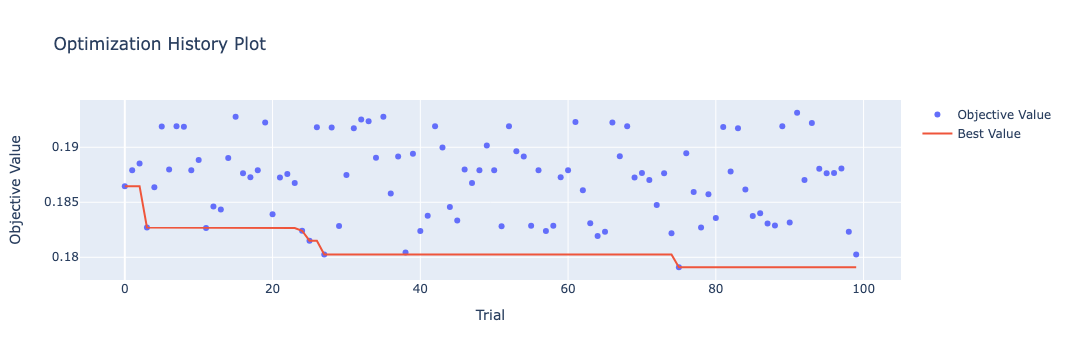

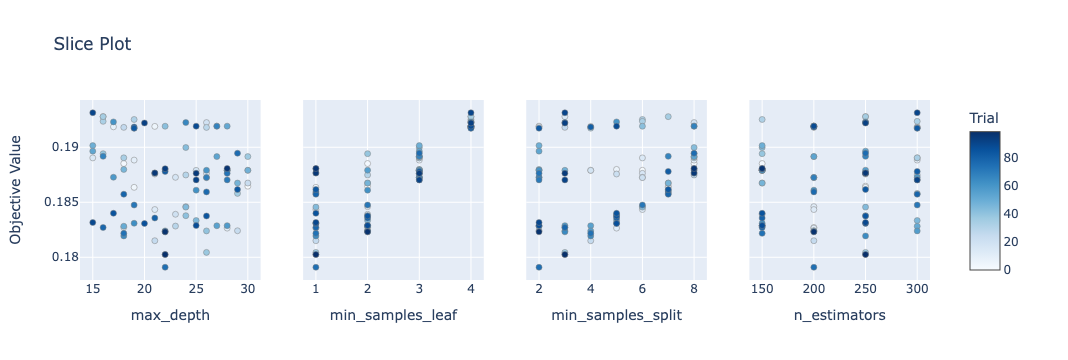

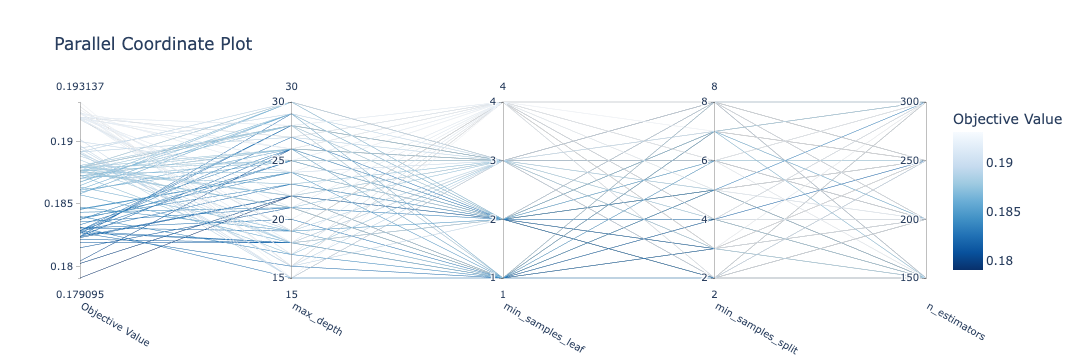

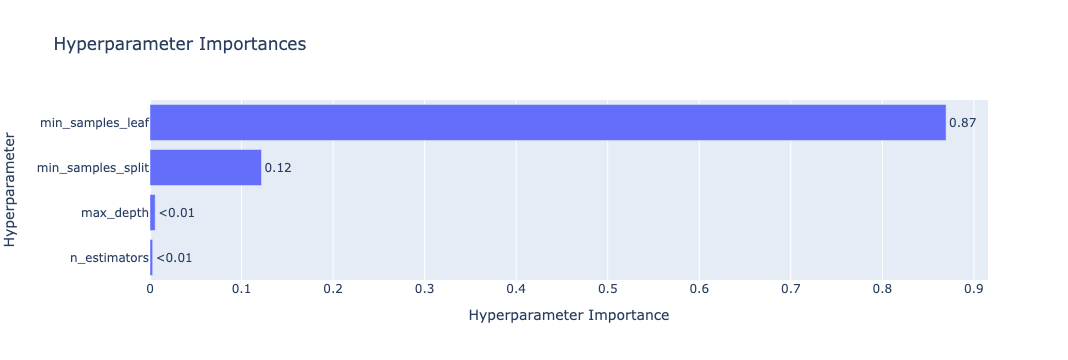

In [1351]:
display(opt_vis.plot_optimization_history(study),
        opt_vis.plot_slice(study),
        opt_vis.plot_parallel_coordinate(study),
        opt_vis.plot_param_importances(study),
       )

In [1352]:
pd.DataFrame(Out[1350].values(), index = Out[1350].keys())

0
n_estimators       200
max_depth           22
min_samples_split    2
min_samples_leaf     1

# XGBoost Code

In [1284]:
x, y, qt, means, stds = rescale_data(transformation_wrapper(raw_data))
ext_x = rescale_data(transformation_wrapper(raw_test_data), train = False, stats = [means, stds])

train, temp_set = train_test_split(raw_data, test_size = 0.2, random_state = 42)
train.sort_values("ID",inplace = True)
temp_set.sort_values("ID",inplace = True)

X_train, y_train, qt, means, stds = rescale_data(transformation_wrapper(train))
temp = rescale_data(transformation_wrapper(temp_set), train = False, stats = [means, stds])
ext_x = rescale_data(transformation_wrapper(raw_test_data), train = False, stats = [means, stds])

temp_X = temp.drop(columns = "tgt_pressure")
temp_y = temp["tgt_pressure"]

X_val, X_test, y_val, y_test = train_test_split(temp_X, temp_y, test_size = 0.4, random_state = 42)

In [1251]:
def xgb_objective(trial, xgb_params, X_train, y_train, X_val, y_val):
    # n_estimators = 150
    max_leaves = trial.suggest_int("max_leaves", xgb_params["max_leaves"][0], xgb_params["max_leaves"][1])
    max_depth = trial.suggest_int("max_depth", xgb_params["max_depth"][0], xgb_params["max_depth"][1])
    min_child_weight = trial.suggest_float("min_child_weight", xgb_params["min_child_weight"][0], xgb_params["min_child_weight"][1])#, log = True)
    # min_child_samples
    learning_rate = trial.suggest_float("learning_rate", xgb_params["learning_rate"][0], xgb_params["learning_rate"][1], log = True)
    min_split_loss = trial.suggest_float("min_split_loss", xgb_params["min_split_loss"][0], xgb_params["min_split_loss"][1], log = True)
    subsample = trial.suggest_float("subsample", xgb_params["subsample"][0], xgb_params["subsample"][1])
    colsample_bytree = trial.suggest_float("colsample_bytree", xgb_params["colsample_bytree"][0], xgb_params["colsample_bytree"][1])
    reg_lambda = trial.suggest_float("reg_lambda", xgb_params["reg_lambda"][0], xgb_params["reg_lambda"][1], log = True)

    xgb_model = XGBRegressor(# n_estimators = n_estimators,
                         max_depth = max_depth,
                         max_leaves = max_leaves,
                         learning_rate = learning_rate,
                         min_child_weight = min_child_weight,
                         min_split_loss = min_split_loss,
                         subsample = subsample,        
                         colsample_bytree = colsample_bytree,
                         reg_lambda = reg_lambda,
        
                         n_jobs = -1,
                         random_state = 42,
                         early_stopping_rounds = 40
                        )
    
    xgb_model.fit(X_train, 
                  y_train, 
                  verbose = False,
                  eval_set = [(X_val, y_val)],
                 )
    
    y_pred = xgb_model.predict(X_val)
    score = mape_calc(y_val, y_pred)
    # print(score)

    # score = - cross_val_score(xgb_model, X_val, y_val, cv = 5, scoring = "neg_mean_absolute_percentage_error", n_jobs = -1).mean()
    
    return score



def train_best_xgb(best_params):
    model = XGBRegressor(
        # n_estimators = 100,
        max_depth = best_params["max_depth"],
        max_leaves = best_params["max_leaves"],
        learning_rate = best_params["learning_rate"],
        min_child_weight = best_params["min_child_weight"],
        subsample = best_params["subsample"],
        colsample_bytree = best_params["colsample_bytree"],
        reg_lambda = best_params["reg_lambda"],
        n_jobs = -1,
        random_state = 42,
    )

    return model


In [1250]:
X_cols = ["sensor_id",
          "failure_pressure", 
          "liquid_pct", 
          "tank_w",
          "tank_l",
          "tank_h",
          "tank_volume",
          "vapor_vol",
          "vapor_energy",
          # "net_vapor_energy",
          "BLEVE_h", 
          "vapour_temp", 
          "liquid_temp", 
          "superheated_status",
          "vapour_height",
          # "1/dist",
          "1/dist_sq",
          # "1/dist_cub",
          # "1/dist_qrt",
          "obstacle_dist",
          "obstacle_w", 
          "obstacle_h",
          "obstacle_thk",
          "obstacle_angle",
         ]

In [1302]:
xgb_params = {"max_leaves": [5,100],
              "max_depth": [3, 25],
              "min_child_weight": [1e-5, 1e-1],
              "learning_rate": [0.2, 0.3],
              "min_split_loss": [1e-5, 1e-3],
              "subsample": [0.5, 1],
              "colsample_bytree": [0.75, 0.9],
              "reg_lambda": [1e-5, 1]
}

In [1303]:
X_train_data = X_train[X_cols]
X_val_data = X_val[X_cols]
y_train_data = y_train.copy()
y_val_data = y_val.copy()
X_test_data = X_test[X_cols]
y_test_data = y_test.copy()

full_X = X_train_data # pd.concat([X_train_data, X_val_data])
full_y = y_train_data # pd.concat([y_train_data, y_val_data])

In [1304]:
study = optuna.create_study(direction = "minimize", sampler = optuna.samplers.RandomSampler(seed = 42))
study.optimize(lambda trial: xgb_objective(trial, xgb_params, X_train_data, y_train_data, X_val_data, y_val_data), n_trials=500, n_jobs=-1)

best_score = study.best_value
best_params = study.best_params

best_xgb = train_best_xgb(best_params)
best_xgb.fit(full_X, 
           full_y, 
           verbose = False,
           eval_set = [(X_val_data, y_val_data)],
          )

y_pred_val = scale_back(best_xgb.predict(X_val_data), y_val_data.index, qt)
y_act_val = y_val_data.copy()

y_pred_test = scale_back(best_xgb.predict(X_test_data), y_test_data.index, qt)
y_act_test = y_test_data.copy()

mape_score_val = mape_calc(y_act_val, y_pred_val)
mape_score_test = mape_calc(y_act_test, y_pred_test)
r2_score_test = r2_score(y_act_test, y_pred_test)
adj_r2_score = adj_r2(y_act_test, y_pred_test, full_X)
rmse_score = root_mean_squared_error(y_act_test, y_pred_test)

ext_pred = scale_back(best_xgb.predict(ext_x[X_cols]), ext_x.index, qt)

[I 2024-05-05 23:14:20,212] A new study created in memory with name: no-name-6a899a8a-20ca-4cb4-b2ac-1729a5d92d68
[I 2024-05-05 23:14:21,530] Trial 4 finished with value: 2.4212120476256414 and parameters: {'max_leaves': 25, 'max_depth': 21, 'min_child_weight': 0.0210826578350516, 'learning_rate': 0.2882357108591853, 'min_split_loss': 0.0002703717623307869, 'subsample': 0.7015439799367449, 'colsample_bytree': 0.8969403789115431, 'reg_lambda': 2.3677845389265977e-05}. Best is trial 4 with value: 2.4212120476256414.
[I 2024-05-05 23:14:21,595] Trial 3 finished with value: 3.566347099911848 and parameters: {'max_leaves': 60, 'max_depth': 5, 'min_child_weight': 0.0014032087755677738, 'learning_rate': 0.2218126501198563, 'min_split_loss': 0.000156231735492188, 'subsample': 0.6925140210933485, 'colsample_bytree': 0.7788086749599253, 'reg_lambda': 1.0470017096917457e-05}. Best is trial 4 with value: 2.4212120476256414.
[I 2024-05-05 23:14:21,652] Trial 1 finished with value: 2.458556259273897

In [1305]:
print(f"Val: \t{mape_score_val:.5f}\nTest: \t{mape_score_test:.5f}\nRMSE: \t{rmse_score:.5f}\nr2: \t{r2_score_test:.5f}\nAdj_r2: {adj_r2_score:.5f}")
# print(f"train = {train_score:.5f} \tval = {val_score:.5f}")

Val: 	0.16053
Test: 	0.15872
RMSE: 	0.18122
r2: 	0.90294
Adj_r2: 0.90041


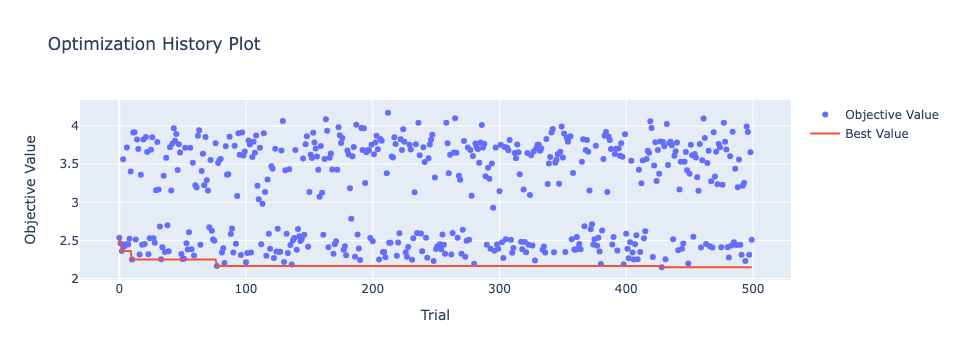

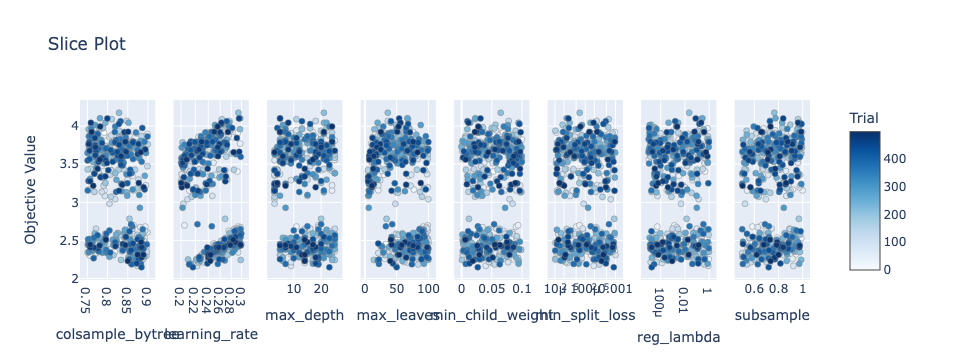

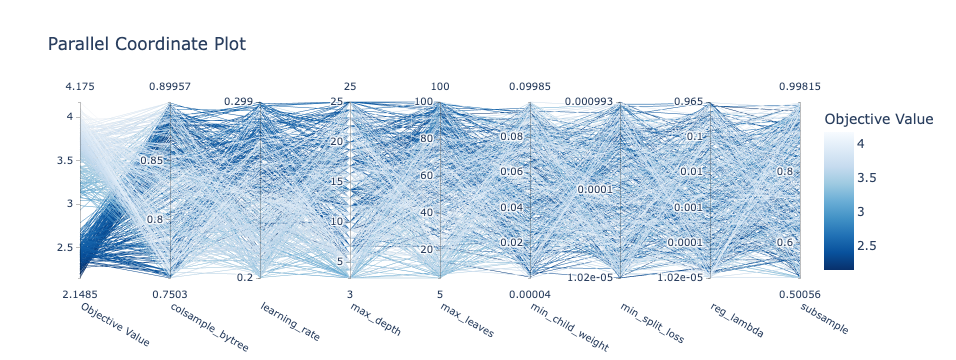

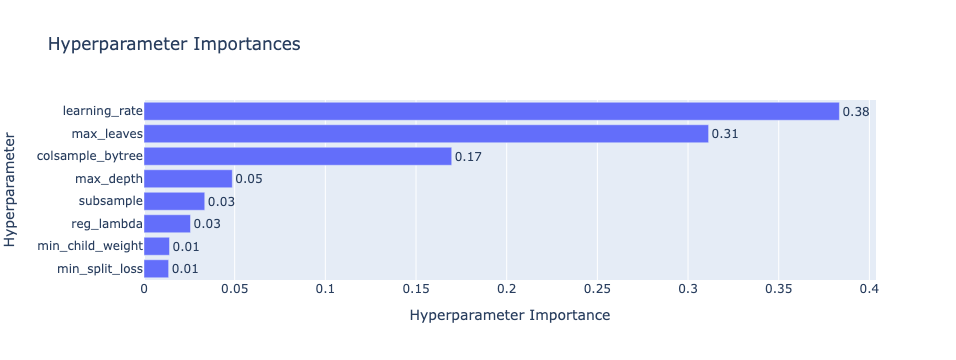

In [1306]:
display(opt_vis.plot_optimization_history(study),
        opt_vis.plot_slice(study),
        opt_vis.plot_parallel_coordinate(study),
        opt_vis.plot_param_importances(study),
       )

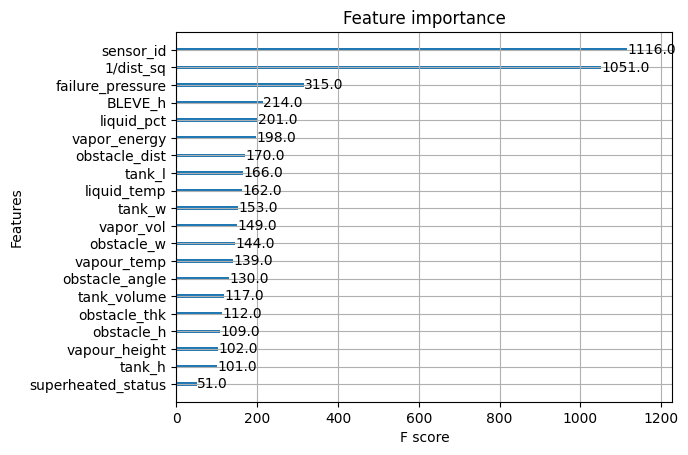

In [1307]:
xgb.plot_importance(best_xgb)
plt.show()

In [1313]:
study.best_params

{'max_leaves': 50,
 'max_depth': 23,
 'min_child_weight': 0.0267240900488612,
 'learning_rate': 0.21652715808073594,
 'min_split_loss': 0.000875978779716614,
 'subsample': 0.7187753684366981,
 'colsample_bytree': 0.8839791604365476,
 'reg_lambda': 1.8050866844496792e-05}

In [1315]:
pd.DataFrame(study.best_params.values(), index = study.best_params.keys())

0
max_leaves        50.000000
max_depth         23.000000
min_child_weight   0.026724
learning_rate      0.216527
min_split_loss     0.000876
subsample          0.718775
colsample_bytree   0.883979
reg_lambda         0.000018

In [1309]:
output_df = pd.DataFrame({'ID': pd.Series(ext_pred).index, 'Target Pressure (bar)': pd.Series(ext_pred).values})
output_df.to_csv('predictions.csv', index=False)

# Neural Networks

In [1316]:
def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return (math.exp(2*x) - 1) / (math.exp(2*x) + 1)

def leaky_relu(x, alpha=0.01):
    return x if x >= 0 else alpha * x

In [1317]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, pred, targets):
        return torch.mean(torch.abs(1 - pred / targets))


class torchNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(17,30),
            nn.ReLU(),
            nn.Linear(30,30),
            nn.ReLU(),
            nn.Linear(30,30),
            nn.ReLU(),
            nn.Linear(30,1),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

In [1353]:
def model_builder(trial): # unch from original
    n_layers = trial.suggest_int("n_layers", 1, 4)
    layers = []
    
    # in_features

    # activation = trial.suggest_categorical("activation", ["ReLU","LeakyReLU", "Mish"])
    n_neurons = trial.suggest_categorical("neurons", [32, 64, 128, 256, 512])
    p = trial.suggest_float("dropout", 0.05, 0.2)

    layers.append(nn.Linear(20, n_neurons))
    # layers.append(nn.Droupout(p))
    
    for i in range(n_layers):
        # if activation == "LeakyReLU":
        #     layers.append(nn.LeakyReLU())
        # elif activation == "ReLU":
        #     layers.append(nn.ReLU())
        # else:
        layers.append(nn.Mish())
  
        layers.append(nn.Dropout(p))
        
        if i+1 == n_layers:
            layers.append(nn.Linear(n_neurons, 1))
        else:
            layers.append(nn.Linear(n_neurons, n_neurons))

        # in_features = out_features

    # layers.append(nn.Softplus())

    return nn.Sequential(*layers)


def nn_objective(trial, X_train, y_train, X_val, y_val):    
    X_torch = torch.tensor(X_train.values, dtype = torch.float32)
    y_torch = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    X_val_torch = torch.tensor(X_val.values, dtype = torch.float32)
    y_val_torch = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    
    nn_model = model_builder(trial)
    # print(nn_model)

    lr = trial.suggest_float("lr",1e-2,5e-1, log = True)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-4, log=True)
    optimizer_name = trial.suggest_categorical("optimizer",["Adam","AdamW"])
    
    # if optimizer_name == "SGD":
        # mu = trial.suggest_float("mu", 0.5, 0.95)
        # optimizer = torch.optim.SGD(nn_model.parameters(), lr = lr, momentum = mu, weight_decay = weight_decay)
    # else:
    optimizer = getattr(torch.optim,optimizer_name)(nn_model.parameters(), lr = lr, weight_decay = weight_decay)
    # optimizer = torch.optim.Adam(nn_model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = CustomLoss()

    #Initialize Variables for EarlyStopping
    best_score = float('inf')
    best_model_weights = None
    patience_val = 50
    patience = patience_val
    
    # n_epochs = trial.suggest_int("n_epochs", 10, 1000)    
    for epoch in range(500):
        optimizer.zero_grad()
        output = nn_model(X_torch)
        loss = criterion(output, y_torch)
        loss.backward()
        optimizer.step()

        # nn_model.eval()
        with torch.no_grad():        
            y_pred = pd.Series(nn_model(X_val_torch).numpy().flatten(), index = X_val.index)
            score = mape_calc(y_val, y_pred)

        if score < best_score:
            best_score = score
            best_model_weights = copy.deepcopy(nn_model.state_dict()) 
            patience = patience_val 
        else:
            patience -= 1
            if patience == 0:
                # print(f"### {epoch-patience_val}: {best_score:.5f} ###")
                break

        
        trial.report(score, epoch)

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_score



def final_model(best_params):
    n_layers = best_params["n_layers"]
    layers = []
    
    n = 20
    # p = best_params["dropout"]
    n_neurons = best_params["neurons"]
    # activation = best_params["activation"]

    layers.append(nn.Linear(n, n_neurons))
    
    for i in range(n_layers):    
        layers.append(nn.Mish())
        layers.append(nn.Dropout(0.1))
        
        if i+1 == n_layers:
            layers.append(nn.Linear(n_neurons, 1))
        else:
            layers.append(nn.Linear(n_neurons, n_neurons))


    # layers.append(nn.Softplus())

    return nn.Sequential(*layers)



def train_best_nn(X_train, y_train, X_val, y_val, best_params):
    model = final_model(best_params)

    X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    X_val_torch = torch.tensor(X_val.values, dtype = torch.float32)
    y_val_torch = torch.tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)

    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    criterion = CustomLoss()

    #Initialize Variables for EarlyStopping
    best_score = float('inf')
    best_model_weights = None
    patience_val = 50
    patience = patience_val
    
    for epoch in range(1000):
        optimizer.zero_grad()
        output = model(X_train_tensor)
        loss = criterion(output, y_train_tensor)        
        loss.backward()
        optimizer.step()
        
        # model.eval()
        with torch.no_grad():      
            y_pred = pd.Series(model(X_val_torch).numpy().flatten(), index = X_val.index)
            score = mape_calc(y_val, y_pred)

        if score < best_score:
            best_score = score
            best_model_weights = copy.deepcopy(model.state_dict()) 
            patience = patience_val 
        else:
            patience -= 1
            if patience == 0:
                # print(f"### {epoch-patience_val}: {best_score:.5f} ###")
                break

    model.load_state_dict(best_model_weights)
    return model


def predict(model, X_test_ext):
    X_ext_tensor = torch.tensor(X_test_ext.values, dtype=torch.float32)
    
    # pd.Series(np.ravel(qt.inverse_transform(pd.DataFrame(y_test_10))), index = y_test_10.index)
    
    with torch.no_grad():
        preds_array = model(X_ext_tensor).numpy().flatten()
        pred = pd.Series(preds_array, X_test_ext.index)

    return pred

In [1354]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(lambda trial: nn_objective(trial, X_train_data, y_train_data, X_val_data, y_val_data), n_trials=100, n_jobs=-1)

best_score = study.best_value
best_params = study.best_params

best_nn = train_best_nn(X_train_data, y_train_data, X_val_data, y_val_data, best_params)
ext_pred = predict(best_nn, ext_x[X_cols])

print(f"Score (unscaled): {best_score:.5f}")

val_mape = mape_calc(pd.Series(np.ravel(qt.inverse_transform(pd.DataFrame(y_val_data))), index = y_val.index), predict(best_nn, X_val_data))
test_mape = mape_calc(pd.Series(np.ravel(qt.inverse_transform(pd.DataFrame(y_test_data))), index = y_test.index), predict(best_nn, X_test_data))
print(f"Val: {val_mape:.5f} \tTest: {test_mape:.5f}")

[I 2024-05-05 23:56:40,196] A new study created in memory with name: no-name-cb8cd70d-540b-4374-a14d-9caa5597578e
[I 2024-05-05 23:56:48,202] Trial 0 finished with value: 0.6144878305501155 and parameters: {'n_layers': 1, 'neurons': 64, 'dropout': 0.14592271648450272, 'lr': 0.053161931749909866, 'weight_decay': 4.735011148310964e-05, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.6144878305501155.
[I 2024-05-05 23:56:50,941] Trial 2 finished with value: 0.6142592687095872 and parameters: {'n_layers': 2, 'neurons': 64, 'dropout': 0.09186510890410518, 'lr': 0.04138750318311751, 'weight_decay': 5.247537772741215e-06, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.6142592687095872.
[I 2024-05-05 23:56:50,961] Trial 1 finished with value: 0.6144832697042131 and parameters: {'n_layers': 2, 'neurons': 32, 'dropout': 0.13515403332839515, 'lr': 0.030036122637663837, 'weight_decay': 1.1191167361125675e-05, 'optimizer': 'Adam'}. Best is trial 2 with value: 0.6142592687095872.
[I 2024-05

Score (unscaled): 0.61426
Val: 0.68628 	Test: 0.68877


In [ ]:
output_df = pd.DataFrame({'ID': pd.Series(ext_pred).index, 'Target Pressure (bar)': pd.Series(ext_pred).values})
output_df.to_csv('predictions.csv', index=False)

# Other 

In [1059]:
temp = transformation_wrapper(raw_data)

In [1068]:
temp["1/dist"] = temp["1/dist_sq"] ** 0.5
temp["net_dist"] = temp["1/dist"] ** -1
temp["1/dist_cub"] = temp["1/dist"] ** 3
temp["1/dist_qrt"] = temp["1/dist"] ** 4
temp["1/dist_qnt"] = temp["1/dist"] ** 5

In [1069]:
temp.corr()["tgt_pressure"][["1/dist_qnt","1/dist_qrt","1/dist_cub","1/dist_sq","1/dist","net_dist"]]

1/dist_qnt    0.437392
1/dist_qrt    0.449316
1/dist_cub    0.451848
1/dist_sq     0.443261
1/dist        0.423897
net_dist     -0.363901
Name: tgt_pressure, dtype: float64

In [ ]:
temp2.query("f > 0").corr()["tgt_pressure"].drop("tgt_pressure").plot(kind = "bar", figsize = (8,4))
plt.show()
temp2.query("f > 0").corr().style.background_gradient(cmap = "bwr", vmin = -1, vmax = 1)